# Macrogenesismodel

## Table of contens



[1. Introduction](#1)<br>
[2. Preparation of XML files by parsing and collecting specific elements](#2)<br>
[3. Generating the graph and computing the FAS](#3)<br>
<span style=padding-left:1em/>[3.1. Graph from the relation-elements](#3-1)<br>
<span style=padding-left:1em/>[3.2. Graph from the date-elements & the creation of the combined graph](#3-2)<br>
[4. Analysis concepts for the contradictions](#4)<br>
<span style=padding-left:1em/>[4.1. Rank sources by normed research scores](#4-1) <br>
<span style=padding-left:1em/>[4.2. Removing nodes and edges by critical sources](#4-2)<br> 
[5. Perfomance comparison of the approaches](#5)<br>
<span style=padding-left:1em/>[5.1. Performance comparison of all current approaches](#5-1)<br>
<span style=padding-left:1em/>[5.2. Adjusting of the Vitt-approach](#5-2)<br>
[6. Creating of the graph](#6)<br>
<span style=padding-left:1em/>[6.1. Longer period graph](#6-1)<br>
<span style=padding-left:2em/>[6.1.1. Minimizing the removal of sources within the FAS](#6-1-1)<br>
<span style=padding-left:2em/>[6.1.2. Deleting whole sources](#6-1-2)<br>
<span style=padding-left:2em/>[6.1.3. Checking by weights](#6-1-3)<br>
<span style=padding-left:1em/>[6.2. Shorter period graph](#6-2)<br>
<span style=padding-left:2em/>[6.2.1. Minimizing the removal of sources within the FAS](#6-2-1)<br>
<span style=padding-left:2em/>[6.2.2. Deleting whole sources](#6-2-2)<br>
<span style=padding-left:2em/>[6.2.3. Checking by weights](#6-2-3)<br>
<span style=padding-left:1em/>[6.3. Vitt graph](#6-3)<br>
<span style=padding-left:2em/>[6.3.1. Minimizing the removal of sources within the FAS](#6-3-1)<br>
<span style=padding-left:2em/>[6.3.2. Deleting whole sources](#6-3-2)<br>
<span style=padding-left:2em/>[6.3.3. Checking by weights](#6-3-3)<br>
<span style=padding-left:1em/>[6.4. Comparison of the created graphs](#6-4)<br>
[7. Conclusion](#7)<br>

In [172]:
from faust_macrogen_graph import parserutils, comparisonutils, analyzeutils, graphutils, eades_fas
from pathlib import Path
import pandas as pd
from collections import Counter, OrderedDict
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, HTML
    
special_researchers = {'faust://bibliography/gsa-datenbank' : 1950, 
                     'faust://self' : 2017, 
                     'faust://bibliography/inventare_2_2': 2011, 
                     'faust://bibliography/aa_duw_2': 1974,
                     'faust://print/faustedition/J.2': 1887, 
                     'faust://bibliography/quz_1': 1966, 
                     'faust://bibliography/quz_2': 1982, 
                     'faust://bibliography/quz_3': 1986,
                     'faust://bibliography/quz_4': 1984,
                     'faust://bibliography/wa_I_13_2': 1901, 
                     'faust://bibliography/wa_I_14' : 1887, 
                     'faust://bibliography/wa_I_15_2' : 1888, 
                     'faust://bibliography/wa_I_53': 1914,
                     'faust://bibliography/wa_IV_13' : 1893}

## 1. Introduction <a class="anchor" id="1"/>

In this notebook we take a detailed look at the macrogenesis of the <b>Faust</b> edition. As explained in the Readme (see: <i>Readme.md</i>), the manuscripts hold the problem that a ordering of all these manuscript by dates isn't possible. One of the reasons are the contradictory datings. These are due to the fact that the inclusion of the various research opinions induces different datings. The goal of the macrogenesis is to create an order with a <b>graph</b> as structure.<br> A graph can be sorted topologically and thus realize the goal of the ordered macrogenesis. To create a topological order the graph has to be acyclic. Due to the contradictions, however, it is not acyclic. To obtain an acyclic graph, edges must be removed. The removed set of edges to make a graph acyclic is called <b>FAS</b> (= Feedback Arc Set or Feedback Edge Set). The algorithm we will use to compute a minimal FAS (MFAS) is by Peter <b>Eades</b> because it is simple, effective and doesn't need a lot of computing power.<br>
Unfortunately, this does not solve the problem. Since the algorithm by Eades tries to compute a <b>minimum</b> FAS, the edges are removed according to this criterion. In fact, it is more interesting for us to delete edges according to the criterion of whole research sources. Therefore, in addition to calculating the FAS, we will also try other methods to integrate as many sources as possible into the graph.
<br>
In doing so, we will base this notebook on the following three questions:
1. How can we integrate the absolute datings? How does the FAS look like with and without the absolute datings?
2. Can a more detailed analysis of the number of edges and the number of contradictions be helpful to decide which edges of which source should be removed?
3. Can erroneously removed edges be re-added without sacrificing performance? How can this be done and how many edges can be re-added?

<u>Brief overview of the main sections</u>

<b>Section 2 &amp; 3</b>: In this sections we generate the graph out of three different graphs. In section 3.1 we generate graphs based on the @temppre- and @tempsyn-relation-elements. In section 3.2 we combine the relation graphs with a generated graph based on the date-elements. Unlike the relation graphs, there are several variants of the date-graph, which is due to the different approaches how to implement the absolute dates. We partly answer the first main question how the integration of the absolute datings look like by comparing the different approaches and choosing the best performing approach for the integration into the graph. A deeper and more detailed comparison of the approaches will appear in <b>section 5 </b>.<br>
<b>Section 4</b>: Here we deal with the answer of the second question. In doing so, we follow a similar approach as the authors of the Faust Edition, by means of which we can compare the sources of the edges according to a specific formula (see: http://faustedition.net/intro_macrogenesis).<br>
<b>Section 5</b>: In this section we will compare the different approaches for the creation of the date graph more exactly than in section 3.2. In addition, we will look at two variants of the Vitt approach, whose special feature is to provide alternative periods between the notBefore and notAfter dates.<br>
<b>Section 6</b>: Here we compare the Vitt graph with his two variants with changed periods of section 5. For all three approaches, an attempt is now made to answer each of the three main questions. The ideas and functions of the previous sections are used and applied to the cyclic or acyclic graph of the respective approach. There are three steps to each approach:
1. Minimizing the removal of sources within the FAS
2. Deleting whole sources
3. Checking by weights<br>

A detailed description of the respective steps is given only in the first subsection, the analyzes of the other two approaches follow the same pattern. Only if there are differences or abnormalities, they are mentioned and explained in more detail.

## 2. Preparation of XML files by parsing and collecting specific elements<a class="anchor" id="2"/>

The <i>xmlparser</i>-function can take up to four arguments: 
1. The path to the XML files
2. A boolean, which indicates, if the parser should parse the date- or the relation-elements
3. A boolean, which indicates, if the parser should parse the @temppre- or @tempsyn-relation-elements
4. A boolean, which indicates, if the date-elements with the @ignore=yes-attribute will be skipped or not

In [92]:
filespath = Path('resources')
temppre_items = parserutils.xmlparser(filespath)
tempsyn_items = parserutils.xmlparser(filespath, False, False)
date_items = parserutils.xmlparser(filespath, True)

## 3. Generating the graph and computing the FAS<a class="anchor" id="3"/>

### 3.1. Graph from the relation-elements<a class="anchor" id="3-1"/> 

First we create two graphs based on the relation elements with the @tempsyn- and @temppre-attributes. We add these graphs later with the graph based on the date elements. The difference between the two relation-element-graphs is that an edge within the tempsyn-graph will get the weight <i>5.0</i> and an edge within the temppre-graph will get the weight <i>1.0</i>. This is done to distinguish the edges later. For both graphs we check if the computing of a FAS is possible. Finally we merge them together into the graph <b>tempG</b>.

In [93]:
tempsynG = nx.DiGraph()
for t in tempsyn_items:
    graphutils.add_egdes_from_node_list(tempsynG, t)
    
if nx.is_directed_acyclic_graph(tempsynG) == True:
    print("The tempsyn graph is acyclic!")
else:
    tempsynG_fas = eades_fas.eades_FAS(tempsynG, True)

    #atempysnG = acyclic tempsyn Graph
    atempsynG = tempsynG.copy()
    atempsynG.remove_edges_from(tempsynG_fas)
    if nx.is_directed_acyclic_graph(atempsynG) == True:
        print("The tempsyn graph without the FAS (" + str(len(tempsynG_fas)) + " edges) is acyclic!")

The tempsyn graph without the FAS (8 edges) is acyclic!


In [94]:
temppreG = nx.DiGraph()
for t in temppre_items:
    graphutils.add_egdes_from_node_list(temppreG, t)

if nx.is_directed_acyclic_graph(temppreG) == True:
    print("The temppre graph is acyclic!")
else:
    temppreG_fas = eades_fas.eades_FAS(temppreG, True)
    
    #atemppreG: acyclic temppre Graph
    atemppreG = temppreG.copy()
    atemppreG.remove_edges_from(temppreG_fas)
    if nx.is_directed_acyclic_graph(atemppreG) == True:
        print("The temppre graph without the FAS (" + str(len(temppreG_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (68 edges) is acyclic!


In [95]:
tempG = nx.compose(tempsynG, temppreG)

if nx.is_directed_acyclic_graph(tempG) == True:
    print("The temppre graph is acyclic!")
else:
    tempG_fas = eades_fas.eades_FAS(tempG, True)
    
    atempG = tempG.copy()
    atempG.remove_edges_from(tempG_fas)
    if nx.is_directed_acyclic_graph(atempG) == True:
        print("The temppre graph without the FAS (" + str(len(tempG_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (81 edges) is acyclic!


### 3.2. Graph from the date-elements & the creation of the combined graph<a class="anchor" id="3-2"/>

For the creation of the date graph we got several approaches of which three doesn't induce a FAS by themselves. As shown by the DataFrame <b>dategraphdf</b>, only the approaches of <b>Vitt</b> and <b>shorter_period</b> induce a FAS by themselves. The reason behind this is that the approaches of <b>Wissenbach, Paulus-1</b> and <b>Paulus-2</b> are not designed to work by themselves.<br> The visualization of the approach of <b>Wissenbach</b> (see <i>resources/vitt_macrogen.pdf, p. 12</i>) shows that it should only be used in conjunction with the tempsyn-elements. The approaches <b>Paulus-1</b> and <b>Paulus-2</b> are made by the author of this notebook and they are for illustrative purposes only.  The basic idea was that that either the "notBefore"-elements or the "notAfter"-elements should be linked to the respective manuscript but not both like the <b>Vitt</b>-approach. Although this did not induce a FAS, the number of nodes and edges was much smaller than the <b>Vitt</b>-approach. However, this is not necessarily helpful for a meaningful integration of the manuscripts, because we want to represent as many manuscripts and connections between the manuscripts as possible.<br>
The approach <b>longer_period</b> is as well as the <b>shorter_period</b>-approach a variant of the <b>Vitt</b>-approach and will be later explained in detail in section 5.2.

In [96]:
approaches = ["vitt", "wissenbach", "paulus-1", "paulus-2", "shorter_period", "longer_period"]
dategraphdf = comparisonutils.compare_approaches(approaches, special_researchers)
dategraphdf

,n nodes,n edges,n cycles,n feedback edges
vitt,731,687,18,18
wissenbach,689,441,0,0
paulus-1,655,441,0,0
paulus-2,649,441,0,0
shorter_period,784,687,18,17
longer_period,781,687,0,0


Since not all approaches induce a FAS on their own, a graph must be created from the relation and date elements and the approaches shall be compared again based on the new graph.

In [97]:
comparisonutils.compare_approaches(approaches, special_researchers, True)

,n nodes,n edges,n cycles,n feedback edges
vitt,967,1643,1711,120
wissenbach,925,1397,480,68
paulus-1,891,1397,480,68
paulus-2,885,1397,480,68
shorter_period,1020,1643,1179,113
longer_period,1017,1643,620,71


The new comparison shows that the <b>Vitt</b>-approach is superior to the other approaches if we omit the approaches <b>shorter_period</b> and <b>longer_period</b>. They are left out for the moment, because, as already mentioned, they are a variant of the <b>Vitt</b> approach and a more detailed analysis of the two approaches will be done in the sections 5.2, 6.1 and 6.2.<br> So we will take the <b>Vitt</b> approach first to represent the date-elements within the graph. 

In [98]:
datesG = graphutils.graph_from_dates(date_items, "vitt", special_researchers)
G = nx.compose(tempG, datesG)
G_fas = eades_fas.eades_FAS(G, True)
aG = G.copy()
aG.remove_edges_from(G_fas)
if nx.is_directed_acyclic_graph(aG) == True:
    print("The graph without the FAS (" + str(len(G_fas)) + " edges) is acyclic!")

The graph without the FAS (130 edges) is acyclic!


The FAS for the whole Graph <b>G</b> contains 130 edges. <b>G</b> contains 1677 edges, 7% of these edge are in the FAS. This percentage is too high and several solution approaches should be tried out to reduce this percentage and the number of edges inside the FAS.

In [99]:
print(str(int((len(G_fas) / len(G.edges())) * 100)) 
      + "% of all edges (" + str(len(G.edges())) 
      + ") of G are in the FAS (" + str(len(G_fas)) + " edges).")

7% of all edges (1677) of G are in the FAS (130 edges).


## 4. Analysis concepts for the contradictions<a class="anchor" id="4"/>

### 4.1. Rank sources by normed research scores<a class="anchor" id="4-1"/>

A characteristic of the in section 3.2 computed FAS is the randomness of the removed edges. The MFAS algorithm by <b>Eades</b> tries to find a minimal solution for the acyclic graph problem. The edges are added to the FAS according to the criterion of their indegree, outdegree and feature as feedback edge. The edge attributes such as the <i>source</i> are disregarded. However, we want both an acyclic graph and a minimum of removed sources which in our case has a higher priority than a MFAS. In this section we take a look at the source attributes of the edges. In the XML files, a dating is attested by a source. The problem is that these sources contradict each other which is certainly the reason for the existence of the FAS. To make the graph acyclic, we have to get rid of these contradictory statements.<br>
We parse through the "source"-attributes of the edges of the graph and return a Counter with a frequency score assigned to each researcher. The idea behind this is that a researcher who contributed more than others will get a much higher score. The problem is that by this method quantity surpasses quality. It is not that simple to compare two academic works by its quality and the resulting benefit for the research because the comparison possibilities are manifold and a detailed comparison would exceed this work. As simplification, we adjust the scores by multiplying each score with a normalized year of the publication of the researchers work about <b>Faust</b>.

<u>An example</u>: <br>
The researcher <b>Anne Bohnenkamp</b> released her work „… das Hauptgeschäft nicht außer Augen lassend“ in 1994. Her work is used as source 354 times within the Faustedition. After the "Weimarer Ausgabe, Abt. I, Bd. 15,2, Weimar 1888" (wa_I_15_2), she is the most named source for the datings. 

We now take a lower and upper range of the possible period of Goethes work on <b>Faust</b> and the release of an scientific work about <b>Faust</b>.<br>
- min_range: 1770 (Goethe began to work on his "Urfaust" 1770) <br>
- max_range: 2017 (According to http://www.faustedition.net/bibliography, the youngest considered work about Faust beside the Faustedition is <i>Brüning / Hahn 2017</i>.)<br>

We now take the year of publication of Bohnenkamps work (= 1994) and subtract it with the lower range. The resulting value is divided by the result of the subtraction of the upper and lower range. The resulting weight is then multiplied by the number of times Bohnenkamp was used as the source within the <b>Faust</b> edition. The result is a normalized representation of the frequency of Bohenkamps appearance within the edition, which decreases less the newer the publication date of the work is.

Bohnenkamp 1994: 354 * ((1994 - 1770) / (2017 - 1770)) = 321.036437

After the normalization Bohnenkamp surpasses the "wa_I_15_2" (see the source DataFrame <i>source_df</i>). We simply assume in this work that datings of newer works are better and more accurately than older works. One of the reasonings behind this is that newer works are able to make their statements against the background of older researchs, while the older researchs are unable to do so. The normalized score will be used in the next section.

In [100]:
#df with research count scores
research_scores = analyzeutils.get_research_score(G)
sorted_research_scores = {k: research_scores[k] 
                              for k in sorted(research_scores, key=research_scores.get, reverse=True)}
research_df = pd.DataFrame(sorted_research_scores.items(), columns=["source", "year_frequency"])
research_df.set_index("source", inplace=True)

#df with normed research count scores
norm_research_scores = analyzeutils.get_norm_research_score(G, special_researchers, 1770, 2017)
sorted_norm_research_scores = {k: norm_research_scores[k]
                              for k in sorted(norm_research_scores, key=norm_research_scores.get, reverse=True)}

norm_research_df = pd.DataFrame(sorted_norm_research_scores.items(), columns=["source", "norm_year_frequency"])
norm_research_df.set_index("source", inplace=True)


#combinig the dfs
source_df = research_df.join(norm_research_df)
source_df[:10]

,year_frequency,norm_year_frequency
source,,
faust://bibliography/wa_I_15_2,450,214.979757
faust://bibliography/bohnenkamp1994,354,321.036437
faust://bibliography/fischer-lamberg1955,346,259.149798
faust://bibliography/landeck1981,142,121.303644
faust://self,140,140.000000
faust://bibliography/hertz1932,76,49.846154
faust://bibliography/gsa-datenbank,27,19.676113
faust://bibliography/inventare_2_2,26,25.368421
faust://bibliography/hertz1931,12,7.821862


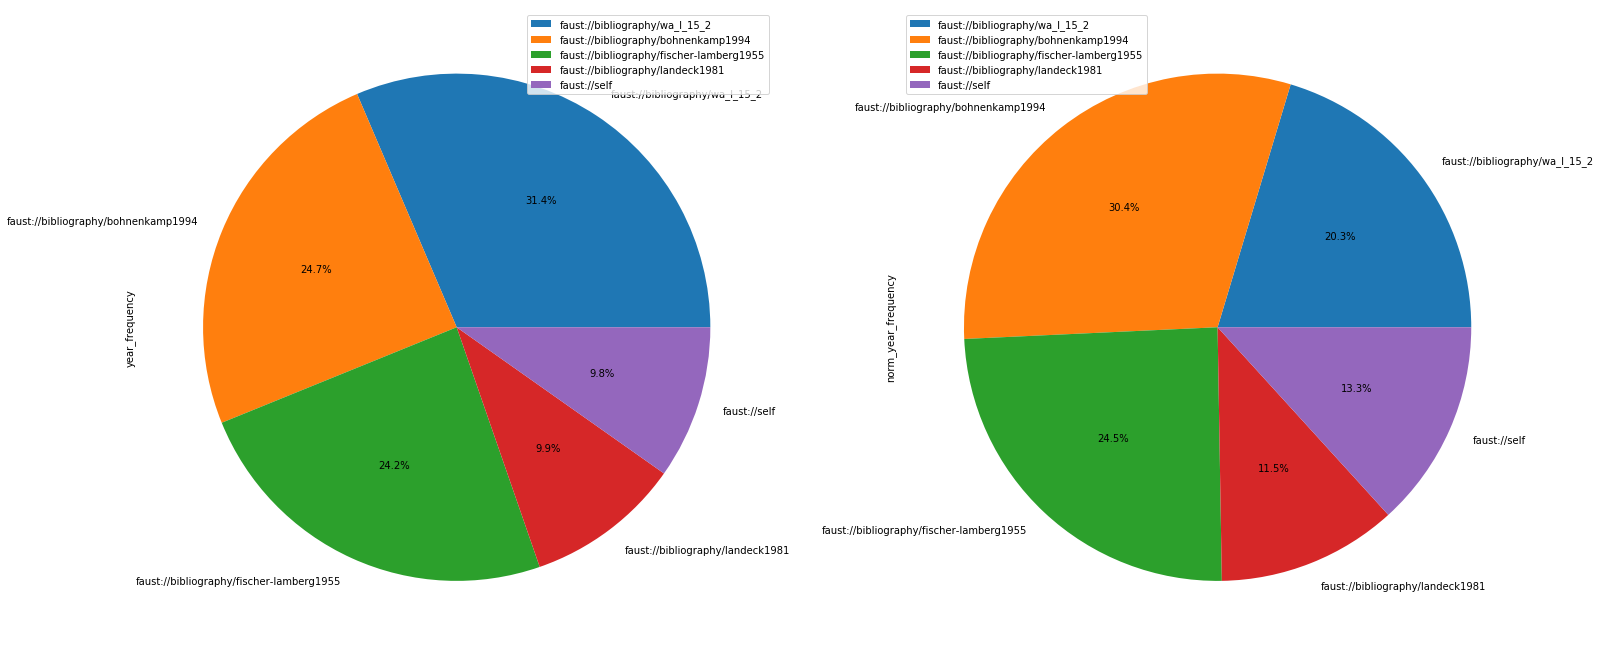

In [101]:
plot = source_df[:5].plot.pie(subplots=True, figsize=(25,25), autopct='%.1f%%')
plt.show()

In [102]:
#df with publication year of the source
year_scores = analyzeutils.get_source_year(G, special_researchers)
year_df = pd.DataFrame(year_scores.items(), columns=["source", "pub_year"])
year_df.set_index("source", inplace=True)

#adding it to the source_df
source_df = source_df.join(year_df)
source_df[:10]

,year_frequency,norm_year_frequency,pub_year
source,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888
faust://bibliography/bohnenkamp1994,354,321.036437,1994
faust://bibliography/fischer-lamberg1955,346,259.149798,1955
faust://bibliography/landeck1981,142,121.303644,1981
faust://self,140,140.000000,2017
faust://bibliography/hertz1932,76,49.846154,1932
faust://bibliography/gsa-datenbank,27,19.676113,1950
faust://bibliography/inventare_2_2,26,25.368421,2011
faust://bibliography/hertz1931,12,7.821862,1931


### 4.2. Removing nodes and edges by critical sources<a class="anchor" id="4-2"/>

After the normalization of the source counts we have to take a deeper look at the <b>Feedback Arc Set</b>. The FAS contains 130 edges. More than a third of the FAS is taken up by "wa_I_15_2" and more than twice as much as the second, third and fourth most common sources by "fischer-lamberg1955", "bohnenkamp1994" and "landeck1981" (see the FAS-frequency DataFrame <i>fasfrequency_df</i>).<br> In this section we try to bypass the computed FAS by trying to make the graph <b>G</b> acylic with the removal of specific sources. We rely on the normed research score of the previous section (see 4.1). The idea behind this is that the FAS has a certain randomness because it tries to compute a minimal solution for the problem (at least if we use the <b>Eades</b> or any other MFAS algorithm). This holds the problem that the removal of the edges to make the graph <b>G</b> acyclic and its randomness makes little sense with regards to content. Against the background of an ideal solution which returns a perfect sorting, the goal is rather to find critical, conflicting sources. Nevertheless, we use the FAS to filter for critical sources and take a closer look a the sources who have the most edges within the FAS.

For a better content but also visual comparison we will use the datastructure <i>DataFrame</i> from the <i>pandas library</i>. The DataFrame <i>df</i> which represents the comparison will be build step by step. The sources of the edges of the FAS determine the index of the DataFrame and the

- frequency of the researcher as manuscript source (<i>year_frequency</i>)
- normed frequency of the researcher as manuscript source (<i>norm_year_frequency</i>)
- publication year of the source (<i>pub_year</i>)
- frequency of the researcher as source of an edge in the FAS (<i>fas_frequency</i>)
- percentage which determines how many edges of an researcher are in the FAS (<i>percent_fas</i>)
- percentage which determines how many edges of an researcher (based on the normalized year frequency) are in the FAS (<i>norm_percent_fas</i>)
- fas size without the removed source (<i>fas_without_source</i>)

determine the seven columns. Each of these columns will be first stored in a DataFrame and later added to the "main"-DataFrame <i>df</i> which is gradually being expanded.

In [103]:
#frequency of the researcher as manuscript source
fasfrequency_df = analyzeutils.gen_frequencyfas(G)
fasfrequency_df

,fas_frequency
source,
faust://bibliography/wa_I_15_2,51
faust://bibliography/fischer-lamberg1955,24
faust://bibliography/bohnenkamp1994,19
faust://bibliography/landeck1981,17
faust://bibliography/hertz1932,7
faust://self,3
faust://bibliography/pniower1899,3
faust://bibliography/bluhm1966,1
faust://bibliography/hertz1931,1


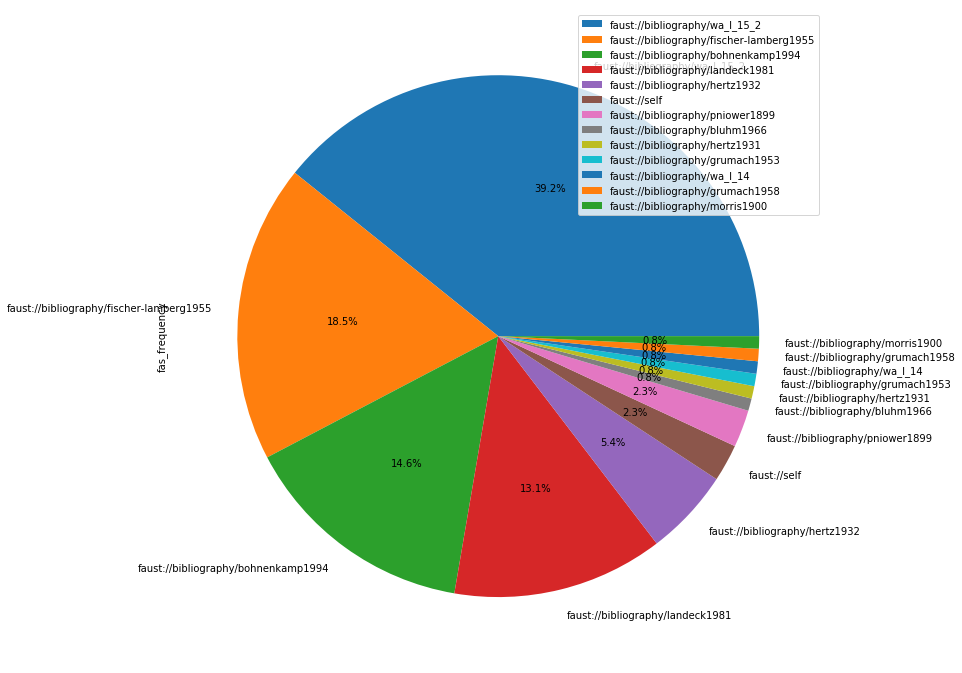

In [104]:
plot = fasfrequency_df.plot.pie(y="fas_frequency", figsize=(12, 12), autopct='%.1f%%')
plt.show()

In [105]:
df = source_df.join(fasfrequency_df)
df = df.dropna() #only sources which are inside the FAS
df

,year_frequency,norm_year_frequency,pub_year,fas_frequency
source,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,51.0
faust://bibliography/bohnenkamp1994,354,321.036437,1994,19.0
faust://bibliography/fischer-lamberg1955,346,259.149798,1955,24.0
faust://bibliography/landeck1981,142,121.303644,1981,17.0
faust://self,140,140.000000,2017,3.0
faust://bibliography/hertz1932,76,49.846154,1932,7.0
faust://bibliography/hertz1931,12,7.821862,1931,1.0
faust://bibliography/wa_I_14,10,4.736842,1887,1.0
faust://bibliography/pniower1899,7,3.655870,1899,3.0


In [106]:
percent_fas = (df["fas_frequency"] / df["year_frequency"]) * 100
norm_percent_fas = (df["fas_frequency"] / df["norm_year_frequency"]) * 100
percentfas_df = pd.concat([percent_fas, norm_percent_fas], axis=1, sort=True)
percentfas_df = percentfas_df.rename(columns={0:"percent_fas", 1:"norm_percent_fas"})
percentfas_df.sort_values(by="percent_fas", ascending=False)
df = df.join(percentfas_df, on="source")
df
#Note: If the following Error raises, restart the code cell with the "df"-variable and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,pub_year,fas_frequency,percent_fas,norm_percent_fas
source,,,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,51.0,11.333333,23.723164
faust://bibliography/bohnenkamp1994,354,321.036437,1994,19.0,5.367232,5.918331
faust://bibliography/fischer-lamberg1955,346,259.149798,1955,24.0,6.936416,9.261053
faust://bibliography/landeck1981,142,121.303644,1981,17.0,11.971831,14.014418
faust://self,140,140.000000,2017,3.0,2.142857,2.142857
faust://bibliography/hertz1932,76,49.846154,1932,7.0,9.210526,14.043210
faust://bibliography/hertz1931,12,7.821862,1931,1.0,8.333333,12.784679
faust://bibliography/wa_I_14,10,4.736842,1887,1.0,10.000000,21.111111
faust://bibliography/pniower1899,7,3.655870,1899,3.0,42.857143,82.059801


For answering the question which complete sources we want to remove to make the Graph acyclic without computing a FAS, we rely on several characteristics a source should have to be rather removed from the Graph than other sources:
1. Very old source 
2. Small amount of edges inside the Graph
3. Large amount of edges inside the FAS
3. A high <b>norm_percent_fas</b>-score<br>

We remove every source of the <i>df</i> from the graph and store the reduced <b>FAS</b> with the assigned source in the DataFrame <i>criticals_df</i>.

If a source meets many of the mentioned characteristics, we remove every edge with the source as attribute and compare how much the FAS shrinkes afterwards.

In [107]:
critical_sources_fas = analyzeutils.gen_critical_sources(G, dict(df["norm_percent_fas"]))

criticals_df = pd.DataFrame(critical_sources_fas.items(), columns=["source", "fas_without_source"])
criticals_df.set_index("source", inplace=True)
df = df.join(criticals_df)
df
#Note: If the following Error raises or the column "fas_without_source" contains only NaN values, 
#restart the code cell with the creation of "df" and it should work.
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,pub_year,fas_frequency,percent_fas,norm_percent_fas,fas_without_source
source,,,,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,51.0,11.333333,23.723164,52
faust://bibliography/bohnenkamp1994,354,321.036437,1994,19.0,5.367232,5.918331,99
faust://bibliography/fischer-lamberg1955,346,259.149798,1955,24.0,6.936416,9.261053,83
faust://bibliography/landeck1981,142,121.303644,1981,17.0,11.971831,14.014418,107
faust://self,140,140.000000,2017,3.0,2.142857,2.142857,125
faust://bibliography/hertz1932,76,49.846154,1932,7.0,9.210526,14.043210,108
faust://bibliography/hertz1931,12,7.821862,1931,1.0,8.333333,12.784679,129
faust://bibliography/wa_I_14,10,4.736842,1887,1.0,10.000000,21.111111,129
faust://bibliography/pniower1899,7,3.655870,1899,3.0,42.857143,82.059801,126


We now take a look at the sources which didn't appear in the "original" FAS and add them to the <b>possible_critical_sources</b>-dictionary if a removal of these sources reduce the FAS.

In [108]:
#scores of all 
scores_all_sources = dict(analyzeutils.get_research_score(G))
all_critical_sources_fas = analyzeutils.gen_critical_sources(G, scores_all_sources)

possible_critical_sources = {}
for k,v in dict(all_critical_sources_fas).items():
    if k not in list(df.index.values) and v < len(G_fas):
        possible_critical_sources[k] = v
possible_critical_sources

{'faust://bibliography/inventare_2_2': 127}

In this section we:
- build a DataFrame <i>df</i> where we took the sources of the FAS as index and several characteristics like the "publication year", the "frequency of the source inside the FAS" or the "size of the FAS without the source" as columns
- computed a dictionary with possible critical sources which aren't in the "original" FAS but could reduce the FAS when they would be removed

These functions and approaches are used to create the graphs in Section 6, where their usefulness and validity for reducing the FAS or removing critical sources is further analyzed and explained.

## 5. Perfomance comparison of the approaches<a class="anchor" id="5"/>

### 5.1. Performance comparison of all current approaches<a class="anchor" id="5-1"/>

In this section we compare all of the current approaches and look at their performance. We already did this in a light variant in <b>section 3.2</b>. There we decided to take the <b>Vitt</b> approach because the computed graph hold more nodes and egdes than the other approaches. We now prove in more detail why using the Vitt-approach or definitely the basic idea of the approach is the best solution for us.<br>
Instead of simply comparing the approaches by the number of nodes and edges, we also test if the ignoring of the skipignore-attributes and changing of the <b>Eades</b>-MFAS-algorithm to the <b>Tintelnot</b>-variant evoke big differences.

In [157]:
#paramlist = [approach, skipignore, eades_fas or tintelnot_fas]
metaparamdict = {"vitt(+skipignore, tintelnot)" : ["vitt", True, True], 
                 "vitt(-skipignore, tintelnot)" : ["vitt", False, True],
                "vitt(+skipignore, eades)" : ["vitt", True, False], 
                 "vitt(-skipignore, eades)" : ["vitt", False, False],
                "wissenbach(+skipignore, tintelnot)" : ["wissenbach", True, True], 
                 "wissenbach(-skipignore, tinelnot)" : ["wissenbach", False, True],
                "wissenbach(+skipignore, eades)" : ["wissenbach", True, False], 
                 "wissenbach(-skipignore, eades)" : ["wissenbach", False, False],
                 "paulus-1(+skipignore, tintelnot)" : ["paulus-1", True, True], 
                 "paulus-1(-skipignore, tinelnot)" : ["paulus-1", False, True],
                "paulus-1(+skipignore, eades)" : ["paulus-1", True, False], 
                 "paulus-1(-skipignore, eades)" : ["paulus-1", False, False],
                 "paulus-2(+skipignore, tintelnot)" : ["paulus-2", True, True], 
                 "paulus-2(-skipignore, tinelnot)" : ["paulus-2", False, True],
                "paulus-2(+skipignore, eades)" : ["paulus-2", True, False], 
                 "paulus-2(-skipignore, eades)" : ["paulus-2", False, False],
                }
meta_feature_dict = {}

for key, paramlist in metaparamdict.items():
    meta_feature_dict[key] = comparisonutils.gen_feature_dict(paramlist, special_researchers, True)

In [158]:
meta_param_df = pd.DataFrame(meta_feature_dict)
meta_param_df = meta_param_df.T
meta_param_df = meta_param_df.drop("nodeslist", 1)
meta_param_df

,cycles,edges,fas,fasfrequency_df,nodes,percentfas_df,source_df
"vitt(+skipignore, tintelnot)",1765,1677,132,fas_...,967,perc...,year...
"vitt(-skipignore, tintelnot)",1765,1677,132,fas_...,969,perc...,year...
"vitt(+skipignore, eades)",1765,1677,132,fas_...,967,perc...,year...
"vitt(-skipignore, eades)",1765,1677,132,fas_...,969,perc...,year...
"wissenbach(+skipignore, tintelnot)",532,1431,79,fas_...,927,perc...,year...
"wissenbach(-skipignore, tinelnot)",532,1431,79,fas_...,927,perc...,year...
"wissenbach(+skipignore, eades)",532,1431,79,fas_...,927,perc...,year...
"wissenbach(-skipignore, eades)",532,1431,79,fas_...,927,perc...,year...
"paulus-1(+skipignore, tintelnot)",532,1431,79,fas_...,893,perc...,year...
"paulus-1(-skipignore, tinelnot)",532,1431,79,fas_...,893,perc...,year...


In [159]:
metadfdict = {"fasfrequency_df" : ["fas_frequency"], 
              "percentfas_df": ["percent_fas","norm_percent_fas"], 
              "source_df": ["year_frequency", "norm_year_frequency"]}

for dataframe, columns in metadfdict.items():
    for column in columns:
        tmp_df = analyzeutils.dataframe_from_column(meta_param_df, dataframe, column)
        print(column)
        display(HTML(tmp_df.to_html()))
        print("\n")

fas_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,19.0,19.0,19.0,19.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
faust://bibliography/fischer-lamberg1955,24.0,24.0,24.0,24.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
faust://bibliography/grumach1953,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/grumach1958,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,9.0,9.0,9.0,9.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/landeck1981,16.0,16.0,16.0,16.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
faust://bibliography/morris1900,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




percent_fas


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,50.000000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,5.352113,5.352113,5.352113,5.352113,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561,1.798561
faust://bibliography/fischer-lamberg1955,6.936416,6.936416,6.936416,6.936416,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405,5.405405
faust://bibliography/grumach1953,16.666667,16.666667,16.666667,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/grumach1958,16.666667,16.666667,16.666667,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,8.333333,8.333333,8.333333,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,11.392405,11.392405,11.392405,11.392405,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488,13.953488
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103
faust://bibliography/landeck1981,11.510791,11.510791,11.510791,11.510791,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750,5.468750
faust://bibliography/morris1900,50.000000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




norm_percent_fas


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,63.010204,63.010204,63.010204,63.010204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,5.901660,5.901660,5.901660,5.901660,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235,1.983235
faust://bibliography/fischer-lamberg1955,9.261053,9.261053,9.261053,9.261053,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947,7.216947
faust://bibliography/grumach1953,22.495446,22.495446,22.495446,22.495446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/grumach1958,21.897163,21.897163,21.897163,21.897163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,12.784679,12.784679,12.784679,12.784679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,17.369902,17.369902,17.369902,17.369902,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763,21.274763
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939
faust://bibliography/landeck1981,13.474718,13.474718,13.474718,13.474718,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807,6.401807
faust://bibliography/morris1900,95.000000,95.000000,95.000000,95.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




year_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/aa_duw_2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/bluhm1966,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
faust://bibliography/bohnenkamp1994,355.0,355.0,355.0,355.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0
faust://bibliography/bruening_hahn2017,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/collin1920,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891a,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891b,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/fischer-lamberg1955,346.0,346.0,346.0,346.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0
faust://bibliography/fischer-lamberg1959,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/frankenberger1926,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




norm_year_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/aa_duw_2,1.651822,1.651822,1.651822,1.651822,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911
faust://bibliography/bluhm1966,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045
faust://bibliography/bohnenkamp1994,321.943320,321.943320,321.943320,321.943320,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360,252.113360
faust://bibliography/bruening_hahn2017,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
faust://bibliography/collin1920,0.607287,0.607287,0.607287,0.607287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891a,1.959514,1.959514,1.959514,1.959514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891b,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879
faust://bibliography/fischer-lamberg1955,259.149798,259.149798,259.149798,259.149798,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405,221.700405
faust://bibliography/fischer-lamberg1959,NaN,NaN,NaN,NaN,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182
faust://bibliography/frankenberger1926,1.263158,1.263158,1.263158,1.263158,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579


Analysis:
- no difference between the <b>Eades</b>- and <b>Tintelnot</b>-FAS for our graph
- Wissenbach- and Paulus-approaches induce more NaN-Values than the Vitt-approach
- the skipignore-attributes have only a small impact: they add "pniower1924" to the <i>year_frequency_df</i>, but doesn't impact the other DataFrames (it doesn't appear inside the FAS).

So we have shown that using the <b>Vitt</b> approach has advantages over the other approaches in Section 3.2 and in this section we proved that the Vitt-approach is the most useful approach for solving our issues. This is not particularly surprising for the Paulus-approaches, as the conjunction of the both apporaches is basically the Vitt approach. The problem with the Wissenbach approach seems to be that it, like the Paulus-approaches, connects only one node that represents the middle of the "notBefore" and "notAfter" dates to the manuscript. So it seems that the <b>basic structure</b> of the Vitt approach of representing "notBefore" and "notAfter" as their own nodes and linking them to the manuscript is the most practical solution. In the following we will manipulate the "notBefore" and the "notAfter" dates in the Vitt approach and see how these changes affect the nodes, edges, cycles and the FAS.

### 5.2. Adjusting of the Vitt-approach<a class="anchor" id="5-2"/>

In this section we manipulate the "notBefore" and "notAfter" datings and compare them with the original datings. The idea of the manipulation is that the "notBefore" and "notAfter" dates were determined by researchers and some assessments do not suit with the assessments of other researchers, which ultimately leads to an acyclic graph and the existence of a FAS. But before we remove the "most critical" sources (see section 4.2), we have a look if we can gain new insights into the problem sources first by adding or removing days from the "notBefore" and "notAfter" elements. However, the ratio should remain the same for the increment of days and the period between days, so the same number of days are always taken or added from the "notBefore" and "notAfter" dates.<br>

Several factors should be considered when comparing these approaches with the Vitt approach:
- <b>Number of nodes</b>: A higher number of nodes is not an indication of a suitable approach by itself, but in the case of a "tie", the approach which has more nodes should be taken.
- <b>FAS size</b>: The smaller the FAS is the better.
- <b>Cycles</b>: The less the better. A small number of cycles becomes interesting, especially for the question of how to get the graph cycle-free without the calculation of a FAS (see Section 4.2).

Hereinafter we reduce the period between "notBefore" and "notAfter" datings by decreasing the dates.

In [160]:
#factor can not be 1 (doesn't make not any sense and doesn't work with our algorithm)
metafactordict = {"vitt" : ["vitt", False, True],
                 "shorter(2)" : ["shorter_period", False, True, 2],
                 "shorter(3)" : ["shorter_period", False, True, 3],
                 "shorter(4)" : ["shorter_period", False, True, 4],
                 "shorter(5)" : ["shorter_period", False, True, 5],
                 "shorter(6)" : ["shorter_period", False, True, 6],
                 "shorter(7)" : ["shorter_period", False, True, 7],
                 "shorter(8)" : ["shorter_period", False, True, 8],
                 "shorter(9)" : ["shorter_period", False, True, 9],
                 "shorter(10)" : ["shorter_period", False, True, 10],
                 "shorter(11)" : ["shorter_period", False, True, 11],
                 "shorter(12)" : ["shorter_period", False, True, 12],
                 "shorter(13)" : ["shorter_period", False, True, 13],
                 "shorter(14)" : ["shorter_period", False, True, 14],
                 "shorter(15)" : ["shorter_period", False, True, 15]}


meta_factor_dict = {}

for key, paramlist in metafactordict.items():
    meta_factor_dict[key] = comparisonutils.gen_feature_dict(paramlist, special_researchers, True)

In [174]:
meta_factor_df = pd.DataFrame(meta_factor_dict)
meta_factor_df = meta_factor_df.T
meta_factor_df = meta_factor_df.drop('fasfrequency_df', 1)
meta_factor_df = meta_factor_df.drop('source_df', 1)
meta_factor_df

,cycles,edges,fas,nodes,nodeslist,percentfas_df
vitt,1765,1677,132,969,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(2),32949,1677,229,968,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(3),788,1677,115,1037,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(4),1482,1677,122,1022,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(5),947,1677,116,1024,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(6),2902,1677,123,1018,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(7),806,1677,118,1015,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(8),936,1677,118,1021,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(9),909,1677,114,1017,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(10),908,1677,118,1021,"[faust://document/faustedition/H_P9, faust://d...",perc...


As we can see here, "shorter (3)" seems to perform best. Compared to the Vitt approach, it induces well under half the number of cycles and the FAS is also smaller. Furthermore, it has more nodes than the Vitt approach. That's because there are many more different datings which resulted from the addition and subtraction of days. Therefore the <b>comparison_nodelist</b> contains only datings.<br>
Note: From factor 15 and from factor 20, the number of cycles has always remained the same, the FAS changed only minimally. Therefore, they were disregarded for comparison, but they are stored under <i>"data/shorter_periods_dataframe.csv"</i>.

In [162]:
shorter3nodelist = meta_factor_df["nodeslist"]["shorter(3)"]
vittnodeslist = meta_factor_df["nodeslist"]["vitt"]

comparison_nodelist = []

for node in shorter3nodelist:
    if node not in vittnodeslist:
        comparison_nodelist.append(node)
        
comparison_nodelist

['1774-03-30 00:00:00',
 '1775-01-18 00:00:00',
 '1776-05-01 00:00:00',
 '1776-09-01 00:00:00',
 '1780-02-12 00:00:00',
 '1784-05-19 00:00:00',
 '1782-05-02 00:00:00',
 '1782-09-01 00:00:00',
 '1786-08-30 00:00:00',
 '1786-11-30 00:00:00',
 '1787-04-09 00:00:00',
 '1787-11-13 00:00:00',
 '1788-09-01 00:00:00',
 '1788-10-20 00:00:00',
 '1789-04-11 00:00:00',
 '1790-05-01 00:00:00',
 '1790-05-31 00:00:00',
 '1791-05-02 00:00:00',
 '1792-09-01 00:00:00',
 '1796-04-28 00:00:00',
 '1796-11-26 00:00:00',
 '1797-09-10 00:00:00',
 '1797-09-21 00:00:00',
 '1797-10-07 00:00:00',
 '1798-01-20 00:00:00',
 '1798-08-08 00:00:00',
 '1799-09-24 00:00:00',
 '1798-08-16 00:00:00',
 '1798-08-31 00:00:00',
 '1798-08-25 00:00:00',
 '1798-09-05 00:00:00',
 '1798-09-27 00:00:00',
 '1800-01-02 00:00:00',
 '1799-03-11 00:00:00',
 '1800-03-21 00:00:00',
 '1799-04-30 00:00:00',
 '1800-05-01 00:00:00',
 '1799-08-05 00:00:00',
 '1799-09-20 00:00:00',
 '1800-02-01 00:00:00',
 '1800-09-04 00:00:00',
 '1800-04-15 00:

And now we try to add days to the "notBefore" and "notAfter" datings.

In [163]:
lmetafactordict = {"vitt" : ["vitt", False, True],
                   "longer(1)" : ["longer_period", False, True, 1],
                   "longer(2)" : ["longer_period", False, True, 2],
                   "longer(3)" : ["longer_period", False, True, 3],
                   "longer(4)" : ["longer_period", False, True, 4],
                   "longer(5)" : ["longer_period", False, True, 5],
                   "longer(6)" : ["longer_period", False, True, 6],
                   "longer(7)" : ["longer_period", False, True, 7],
                   "longer(8)" : ["longer_period", False, True, 8],
                   "longer(9)" : ["longer_period", False, True, 9],
                   "longer(10)" : ["longer_period", False, True, 10],
                   "longer(11)" : ["longer_period", False, True, 11],
                  "longer(12)" : ["longer_period", False, True, 12],
                  "longer(13)" : ["longer_period", False, True, 13],
                  "longer(14)" : ["longer_period", False, True, 14],
                  "longer(15)" : ["longer_period", False, True, 15]}


lmeta_factor_dict = {}

for key, paramlist in lmetafactordict.items():
    lmeta_factor_dict[key] = comparisonutils.gen_feature_dict(paramlist, special_researchers)

In [175]:
lmeta_factor_df = pd.DataFrame(lmeta_factor_dict)
lmeta_factor_df = lmeta_factor_df.T
lmeta_factor_df = lmeta_factor_df.drop('fasfrequency_df', 1)
lmeta_factor_df = lmeta_factor_df.drop('source_df', 1)
lmeta_factor_df

,cycles,edges,fas,nodes,nodeslist,percentfas_df
vitt,1711,1643,120,967,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(1),480,1643,69,1016,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(2),503,1643,69,1012,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(3),5592,1643,70,1012,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(4),620,1643,71,1017,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(5),481,1643,70,1019,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(6),1384,1643,69,1014,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(7),481,1643,68,1015,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(8),480,1643,68,1022,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(9),480,1643,69,1025,"[faust://document/faustedition/H_P9, faust://d...",perc...


The best performing approach is "longer(11)", although there aren't many distinct differences between the seperate approaches. A comparison of the period-parameters is stored unde <i>data/longer_periods_dataframe.csv</i>. There we can see that, from factor 16 the cycles, the FAS and the number of nodes don't vary much.

## 6. Creating of the graph<a class="anchor" id="6"/> 

This section is the main section of this notebook. In the previous sections we have seen how to create a graph from the XML dating elements (see Section 3) and which approaches there are for implementing the absolute datings and how they perform in comparison to the other approaches (see Section 3.2 and 5). We also looked more closely at dating sources, determined a normalization formula for these sources and developed functions and approaches that use the removal of specific sources to make the graph acyclic (see Section 4).<br>

In this section we apply all these methods, approaches and functions to the graphs of the <b>longer-period</b>, <b>shorter-period</b> and <b>Vitt</b> approaches. Each of these approaches is dedicated to a separate section, which is subdivided into three subsections: <br>
In the first section, we try to minimize the FAS by adding edges back to the graph. It should be checked if we can add edges by specific sources and how many edges we can add with this method.<br>
In the second section, we bypass the FAS and delete entire sources from the cyclic graph according to certain criteria, trying to obtain acyclic graphs. <br>
In the third section we look at the edge weights of the feedback edges and see how many important edges have been removed from the graph and whether they should be added back to the graph. <br>

In section 6.1, the individual steps are explained in detail. However, since most of the approaches of sections 6.2 and 6.3 are the same as in section 6.1, only differences and new insights are explained in more detail; the same processes are not explained again. Finally, in section 6.4, the insights of the three previous sections are compared and evaluated with the help of the <i>meta_vitt_df</i>.

In [117]:
meta_vitt_df = pd.DataFrame(0, index=["longer", "shorter", "vitt"], 
                            columns=["edges",
                                     "nodes",
                                     "fas_size", 
                                     "possible reduced fas",
                                     "aG_edges+uncritical_source",
                                     "aG_edges+random_critical_sources",
                                     "complete_sources_readded",
                                     "critical_weights"])

### 6.1. Longer period graph<a class="anchor" id="6-1"/>

In [118]:
lGparams = ["longer_period", False, True, 11]
lG = graphutils.gen_faustgraph(lGparams, special_researchers, True)
lG_fas = eades_fas.eades_FAS(lG, True)
meta_vitt_df.loc["longer","fas_size"] = len(lG_fas)
meta_vitt_df.loc["longer","edges"] = len(lG.edges())
meta_vitt_df.loc["longer","nodes"] = len(lG.nodes())

Checking if the FAS is computed correctly.

In [119]:
alG = lG.copy()
alG.remove_edges_from(lG_fas)
if nx.is_directed_acyclic_graph(alG) == True:
    print("The longer graph without the FAS (" + str(len(lG_fas)) + " edges) is acyclic!")

The longer graph without the FAS (79 edges) is acyclic!


#### 6.1.1. Minimizing the removal of sources within the FAS<a class="anchor" id="6-1-1"/>

In this section, we remove individual edges of critical sources to make the FAS smaller[<sup>1</sup>](#fn1). As little sources as possible should be used and as few edges as possible. An ideal solution would only remove some edges from one source. These could then be implemented relatively easy in the <b>Faust</b>-Edition and treated as "invalid or incorrect statements". Since it is already clear from the outset that we will not be able to do this, we try to find the best sequence of sources to be removed so that the graph becomes cycle-free. Only the order in which most sources can still stay in the graph is examined. Using this order, the edges of the sources, which are not likely to generate a new FAS, are then gradually added back to the acyclic graph <b>alG</b>. On the other hand, the experiment is then confronted with a random, not source-oriented, new acquisition of edges, and both experiments are then compared.<br><br>


<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp;This is possible because the MFAS-algorithm of <b>Eades</b> tries to compute a minimal FAS but can't offer a truly minimal solution, because the removal of cycles within a graph is one of Karps 21 NP-complete problems (see: https://en.wikipedia.org/wiki/Karp%27s_21_NP-complete_problems).</span>

In [120]:
"""Note: Because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as 
      "longer_period_fas_dataframe.csv" to save time."""
#lGfas_df = analyzeutils.minimize_source_removal(lG)
#lGfas_df.to_csv("data/longer_period_fas_dataframe.csv")

'Note: Because the FAS-alogrithm is called many times, this function is a little bit slow. \n      We saved the DataFrame in the folder "data" as \n      "longer_period_fas_dataframe.csv" to save time.'

In [121]:
lGfas_df = pd.read_csv("data/longer_period_fas_dataframe.csv", index_col="source")
lGfas_df

,faust://bibliography/wa_I_15_2,faust://bibliography/fischer-lamberg1955,faust://bibliography/landeck1981,faust://bibliography/hertz1932,faust://bibliography/bohnenkamp1994,faust://self,faust://bibliography/inventare_2_2
source,,,,,,,
faust://bibliography/wa_I_15_2,1,1,1,1,0,0,0
faust://bibliography/fischer-lamberg1955,1,1,1,1,0,0,0
faust://bibliography/landeck1981,1,1,1,1,0,0,0
faust://bibliography/hertz1932,1,1,1,1,0,0,0
faust://bibliography/bohnenkamp1994,1,1,1,1,1,0,0
faust://self,1,1,1,1,0,1,0
faust://bibliography/inventare_2_2,1,1,1,1,0,0,1


In [122]:
lG_fas_frequency = analyzeutils.gen_frequencyfas(lG)

uncritical_sources, reduced_fas = analyzeutils.remove_uncritical_sources(lG, lG_fas, lG_fas_frequency, lGfas_df)
meta_vitt_df.loc["longer", "possible reduced fas"] = len(lG_fas) - reduced_fas

The FAS is still there and contains 2 edges.


Re-adding the source zero values and all critical sources for comparison. The function "readding_edges_by_source" only adds an edge if this edge doesn't create a new cycle.

In [123]:
critical_sources = list(lG_fas_frequency.index)

#Testing with only the uncritical source
uc_alG = graphutils.readding_edges_by_source(lG, alG, lG_fas, uncritical_sources)
meta_vitt_df.loc["longer","aG_edges+uncritical_source"] = len(uc_alG.edges()) - len(alG.edges())

#Testing with all critical sources
c_alG, readded_edgelist = graphutils.readding_edges_by_source(lG, alG, lG_fas, critical_sources, True)
meta_vitt_df.loc["longer","aG_edges+random_critical_sources"] = len(c_alG.edges()) - len(alG.edges())

print("The acyclic longer period graph has " 
      + str(len(alG.edges())) 
      + " edges. If only the sources of the uncritical sources should be added, the longer period graph contains now " 
      + str(len(uc_alG.edges())) 
      + " edges. If all critical sources should be added, the graph contains "
      + str(len(c_alG.edges()))
      + " edges.")
if nx.is_directed_acyclic_graph(uc_alG) and nx.is_directed_acyclic_graph(uc_alG):
    print("Both versions of the alG graph are still acylic.")
if len(uc_alG.edges()) == len(alG.edges()):
    print("With the addition of the uncritical sources, the graph stayed the same.")
if len(uc_alG.edges()) > len(alG.edges()):
    print("With the addition of the uncritical sources, the graph now contains "
         + str(len(uc_alG.edges()) - len(alG.edges())) + " edges more than before.")
if len(c_alG.edges()) > len(alG.edges()):
    print("With the addition of the critical sources, the graph now contains "
         + str(len(c_alG.edges()) - len(alG.edges())) + " edges more than before.")

The acyclic longer period graph has 1598 edges. If only the sources of the uncritical sources should be added, the longer period graph contains now 1600 edges. If all critical sources should be added, the graph contains 1613 edges.
Both versions of the alG graph are still acylic.
With the addition of the uncritical sources, the graph now contains 2 edges more than before.
With the addition of the critical sources, the graph now contains 15 edges more than before.


Testing whether all edges have been added from one of the sources, from which edges were added to the acyclic graph alG again.

In [124]:
edgecounter = Counter()
for edge in readded_edgelist:
    edgecounter[edge[3]] += 1

complete_readded_sources = []
for source, v in edgecounter.items():
    if lG_fas_frequency.loc[source, "fas_frequency"] <= v:
        complete_readded_sources.append(source)
        print("The whole source " + source + " should be re-added (" 
              + str(int(lG_fas_frequency.loc[source])) + " edge(s) inside the FAS).")
meta_vitt_df.loc["longer","complete_sources_readded"] = len(complete_readded_sources)  

The result is quite sobering. It was not possible for us to insert more than two edges from the FAS into the graph according to the criterion of seemingly uncritical sources. Instead, however, we were able to add 15 single edges that, while coming from the critical source area, were randomly added and not by the criterion of a specific source. This does prove that the MFAS-algorithm of <b>Eades</b> isn't the minimal solution for the FAS-problem. Although we did not achieve our goal of reducing the number of sources within the FAS, we were able to add random edges of the FAS back to the <b> alG </b> graph without sacrificing performance or creating new cycles.

#### 6.1.2. Deleting whole sources<a class="anchor" id="6-1-2"/>

Since we could not add any edges from certain sources back from the FAS to the graph, we try two more strategies:
- We remove sources with the largest proportion of the FAS from the cyclic graph <b>lG</b>. A minimum should be preferred,  i.e. as few sources as possible (keyword: <i>"norm_percent_fas"</i>-score & <i>"fas_without_source"</i>-score)
- We gradually remove  sources from the list of all sources until we generate an acyclic graph or a very small FAS (keyword: <i>"norm_year_frequency"</i>-score). Again, a minimum would be preferable.<br>

In the following, we will create a <b> norm_df </b> which will calculate the "norm_year_frequency"-score, the "norm_percent_fas"-score and the size of the FAS without the sources for each source of the FAS (for an explanation of the scores see section 4.1).

In [125]:
norm_df = analyzeutils.get_normdf(lG, special_researchers, True, min_range=1770, max_range=2017)
norm_dict = dict(norm_df["norm_percent_fas"])
fas_dict = {}
for k,v in norm_dict.items():
    nG = graphutils.remove_edges_by_source(lG.copy(), k)
    nG_fas = eades_fas.eades_FAS(nG, True)
    fas_dict[k] = len(nG_fas)
    

fas_df = pd.DataFrame(fas_dict.items(), columns=["source", "fas_without_source"])
fas_df.set_index("source", inplace=True)
norm_df = norm_df.join(fas_df, on="source")
norm_df.sort_values(by="fas_without_source")

norm_df = norm_df.sort_values(by="fas_without_source")
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/wa_I_15_2,214.502024,19.114039,22
faust://bibliography/fischer-lamberg1955,259.149798,6.174035,53
faust://bibliography/landeck1981,118.740891,5.895189,68
faust://bibliography/hertz1932,51.813765,11.579934,70
faust://bibliography/bohnenkamp1994,321.943320,1.553068,70
faust://bibliography/inventare_2_2,25.368421,3.941909,78
faust://self,140.000000,2.142857,80


There is no source whose sole removal from the graph would make the graph acyclic. As we saw in the previous section, this does not work with a minimal combination of sources of the FAS either. Now we are changing our approach. Instead of gradually removing the sources, preserving some certain orders, we try all possible combinations of sequences (720 combinations in the <b>lG</b> graph) to find a minimal order. But instead of removing the FAS directly, we first try to find the minimal FAS, which is possible by removing two sources (see <i> minimize_rm_source_df </i>).

In [126]:
"""Note: The algorithm will take a while so we saved the minimize_rm_source_df to a csv."""
#minimize_rm_source_df = analyzeutils.minimize_fas_by_source_removal(lG.copy())
#minimize_rm_source_df.to_csv("data/minimize_rm_source_df(longer-period)")
minimize_rm_source_df = pd.read_csv("data/minimize_rm_source_df(longer-period)", index_col="source")
minimize_rm_source_df

,faust://bibliography/wa_I_15_2,faust://bibliography/fischer-lamberg1955,faust://bibliography/landeck1981,faust://bibliography/hertz1932,faust://bibliography/bohnenkamp1994,faust://self,faust://bibliography/inventare_2_2
source,,,,,,,
faust://bibliography/wa_I_15_2,22,11,18,17,21,21,22
faust://bibliography/fischer-lamberg1955,11,53,42,44,42,50,51
faust://bibliography/landeck1981,18,42,68,63,59,68,67
faust://bibliography/hertz1932,17,44,63,70,60,71,69
faust://bibliography/bohnenkamp1994,21,42,59,60,70,68,69
faust://self,21,50,68,71,68,80,79
faust://bibliography/inventare_2_2,22,51,67,69,69,79,78


We look for the lowest value (= 11), reduce it by 1 and use it as a parameter for our next function. The function <b>find_optimal_order</b> takes the sources of the FAS of the input graph and tries to create a FAS with all combination of six[<sup>1</sup>](#fn1) sources (720 combinations) which is smaller than the parameter 10 (= lowest value - 1). However, 10 is still a very large value, which is why we aim for an empty FAS here.
We're trying to find a FAS that not only removes two, but eventually multiple sources and cause the FAS to drop edges. An ideal solution would be an order of three or fewer sources that ideally do not produce a FAS. The result of the <b>find_optimal_order</b> function was stored in a pickle file "data/optimal_order_dict_lG(p=0).pkl" because the function takes a long time (~ 3 hours) due to the 720 combinations, where a FAS is generated for each combination.

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp;We chose six as the maximimum of input sources because otherwise we would lose performance.</span>

In [127]:
"""
Note: because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as "data/optimal_order_dict_lG(p=0).pkl" to save time.
"""
#optimal_order_dict = analyzeutils.find_optimal_order(lG, minimize_rm_source_df, 0)
#with open('data/'+ "optimal_order_dict_lG(p=" + str(param) + ")" + ".pkl", "wb") as f:
#    pickle.dump(optimal_order_dict, f, pickle.HIGHEST_PROTOCOL)

'\nNote: because the FAS-alogrithm is called many times, this function is a little bit slow. \n      We saved the DataFrame in the folder "data" as "data/optimal_order_dict_lG(p=0).pkl" to save time.\n'

In [128]:
param = 0
with open('data/' + "optimal_order_dict_lG(p=" + str(param) + ")" + '.pkl', 'rb') as f:
    optimal_order_dict = pickle.load(f)
    min_fas_with_min_optorder = analyzeutils.minimum_of_optimal_order(optimal_order_dict)
    min_optorder_with_min_fas = analyzeutils.minimum_of_optimal_order(optimal_order_dict, False)
    print("fas_size: " + str(min_fas_with_min_optorder[0]) + "\nopt_order_size: " 
          + str(len(min_fas_with_min_optorder[1]))
          + "\nopt_order: " + str(min_fas_with_min_optorder[1]))
    print("\nfas_size: " + str(min_optorder_with_min_fas[0]) + "\nopt_order_size: " 
          + str(len(min_optorder_with_min_fas[1]))
          + "\nopt_order: " + str(min_optorder_with_min_fas[1]))

fas_size: 0
opt_order_size: 4
opt_order: ['faust://bibliography/wa_I_15_2', 'faust://bibliography/fischer-lamberg1955', 'faust://bibliography/landeck1981', 'faust://bibliography/hertz1932']

fas_size: 0
opt_order_size: 4
opt_order: ['faust://bibliography/wa_I_15_2', 'faust://bibliography/fischer-lamberg1955', 'faust://bibliography/landeck1981', 'faust://bibliography/hertz1932']


Unfortunately, we did not reach our ideal solution of 3 sources and a FAS of length=0. The other solutions show that we need at least 4 sources to make the graph acyclic.

In [129]:
for k,v in optimal_order_dict.items():
    if v["fas_size"] == min_fas_with_min_optorder[0] and v["opt_order"] == min_fas_with_min_optorder[1]:
        if "faust://bibliography/fischer-lamberg1955" and "faust://bibliography/wa_I_15_2" not in v["opt_order"]:
            print(k)
            
for k,v in optimal_order_dict.items():
    if v["fas_size"] == min_optorder_with_min_fas[0] and v["opt_order"] == min_optorder_with_min_fas[1]:
        if "faust://bibliography/fischer-lamberg1955" and "faust://bibliography/wa_I_15_2" not in v["opt_order"]:
            print(k)

However, since each of these orders includes the sources "fischer-lamberg1955" and "wa_I_15_2", it makes more sense to directly remove these two sources and manually remove the remaining edges of the FAS (see <i> minimize_rm_source_df </i>).

In [130]:
lG_test = lG.copy()
lG_test = graphutils.remove_edges_by_source(lG_test, norm_df.index[0]) #"wa_I_15_2"
lG_test = graphutils.remove_edges_by_source(lG_test, norm_df.index[1]) #"fischer-lamberg1955"
lG_test_fas = eades_fas.eades_FAS(lG_test, True)

for edge in lG_test_fas:
    if lG.has_edge(edge[0], edge[1]):
        edge_data = lG.get_edge_data(edge[0], edge[1])
        print(edge_data)

{'weight': 5.0, 'source': 'faust://bibliography/hertz1932'}
{'weight': 1.0, 'source': 'faust://bibliography/landeck1981'}
{'weight': 5.0, 'source': 'faust://bibliography/hertz1932'}
{'weight': 1.0, 'source': 'faust://self'}
{'weight': 5.0, 'source': 'faust://bibliography/hertz1932'}
{'weight': 1.0, 'source': 'faust://bibliography/landeck1981'}
{'weight': 5.0, 'source': 'faust://bibliography/landeck1981'}
{'weight': 5.0, 'source': 'faust://bibliography/bohnenkamp1994'}
{'weight': 5.0, 'source': 'faust://bibliography/hertz1932'}
{'weight': 5.0, 'source': 'faust://bibliography/landeck1981'}
{'weight': 5.0, 'source': 'faust://bibliography/bohnenkamp1994'}


As a conclusion from this section, we can say that deleting by sources is not as effective as deleting problematic edges, but would make more sense in terms of content. Unfortunately, we were unable to bypass the problem sources "fischer-lamberg1955" and "wa_I_15_2" because they cover a large proportion of the graph nodes (the have the lowest "fas_without_source"-values within the <b>norm_df</b>). But we were able to exclude the sources except for two edges "bohnenkamp1994" and except for two edges "landeck1981" and one edge of "faust://self", which are the other three major research sources, from the FAS.[<sup>1</sup>](#fn1) If we look at the <b>norm_df</b>, we see that "bohnenkamp1994" holds the first place at the <i>norm_year_frequency</i>-score and "faust://self" and "landeck1981" the fourth and fifth place. All three source together have only a slighlty bigger <i>norm_percent_fas</i>-score like "fischer-lamberg1955" and only about a third of the <i>norm_percent_fas</i>-score of "wa_I_15_2". The "Re-adding" of those sources would decrease the amount of sources within the FAS which is one of our goals.

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; In addition, there is Hertz1932, but this source seems to have been classified as dispensable by the authors of the <b>Faust edition</b>, see http://faustedition.net/intro_macrogenesis.</span>

In [131]:
norm_df = norm_df.sort_values(by="norm_year_frequency", ascending=False)
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/bohnenkamp1994,321.943320,1.553068,70
faust://bibliography/fischer-lamberg1955,259.149798,6.174035,53
faust://bibliography/wa_I_15_2,214.502024,19.114039,22
faust://self,140.000000,2.142857,80
faust://bibliography/landeck1981,118.740891,5.895189,68
faust://bibliography/hertz1932,51.813765,11.579934,70
faust://bibliography/inventare_2_2,25.368421,3.941909,78


#### 6.1.3. Checking by weights<a class="anchor" id="6-1-3"/>

Finally, we see if the edges of the FAS can be ranked based on their edge weight. There are three edge weights: "1.0", "5.0" and "10.0". Edges with the weight "10.0" are edges that represent a @when-attribute of a date element and should stay in the graph, because they give us a precise release time for a manuscript. Edges with the weight "5.0" are edges that represent a @tempsyn-relation-element. The @tempsyn-relation-elements state that two manuscripts were written at about the same time. One way to represent them in the graph would be to insert two parallel edges. Due to complexity reasons, however, it was implemented like the @temppre-relation elements, but with a different weight. None of the edges of the FAS have a "10.0" weight and 9 edges with a "5.0" weight are in the FAS. The importance of this size and an analysis will be given in section 6.4.

In [132]:
#checking by weights
critical_weights = []
for t in list(lG_fas):
    if t[2] >= 5.0:
        critical_weights.append(t)
        print(t)
        
meta_vitt_df.loc["longer","critical_weights"] = len(critical_weights)

('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://inscription/faustedition/2_V_H.4/i_uebrige', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://inscription/faustedition/2_V_H.8/i_uebrige', 5.0)
('faust://document/faustedition/2_V_H.2', 'faust://inscription/faustedition/2_V_H.31/i_r_o', 5.0)
('faust://inscription/faustedition/2_V_H.31/i_r_uebrige', 'faust://document/faustedition/2_V_H.2', 5.0)
('faust://document/faustedition/2_IV_H.22d', 'faust://document/faustedition/2_IV_H.21a', 5.0)
('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://document/faustedition/2_V_H.25', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://document/faustedition/2_V_H.25', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://document/faustedition/2_V_H.10', 5.0)
('faust://document/wa/2_IV_H.g', 'faust://document/faustedition/2_IV_H.1', 5.0)


### 6.2. Shorter period graph<a class="anchor" id="6-2"/>

In [176]:
sGparams = ["shorter_period", False, True, 3]
sG = graphutils.gen_faustgraph(sGparams, special_researchers, True)
sG_fas = eades_fas.eades_FAS(sG, True)
meta_vitt_df.loc["shorter","fas_size"] = len(sG_fas)
meta_vitt_df.loc["shorter","edges"] = len(sG.edges())
meta_vitt_df.loc["shorter","nodes"] = len(sG.nodes())

asG = sG.copy()
asG.remove_edges_from(sG_fas)
if nx.is_directed_acyclic_graph(asG) == True:
    print("The shorter graph without the FAS (" + str(len(sG_fas)) + " edges) is acyclic!")

The shorter graph without the FAS (115 edges) is acyclic!


#### 6.2.1. Minimizing the removal of sources within the FAS<a class="anchor" id="6-2-1"/>

In [134]:
"""
Note: because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as "longer_period_fas_dataframe.csv" to save time.
"""
#sGfas_df = analyzeutils.minimize_source_removal(sG)
#sGfas_df.to_csv("data/shorter_period_fas_dataframe.csv")

'\nNote: because the FAS-alogrithm is called many times, this function is a little bit slow. \n      We saved the DataFrame in the folder "data" as "longer_period_fas_dataframe.csv" to save time.\n'

In [135]:
sGfas_df = pd.read_csv("data/shorter_period_fas_dataframe.csv", index_col="source")

sG_fas_frequency = analyzeutils.gen_frequencyfas(sG)
uncritical_sources, reduced_fas = analyzeutils.remove_uncritical_sources(sG, sG_fas, 
                                                                         sG_fas_frequency, sGfas_df)
meta_vitt_df.loc["shorter", "possible reduced fas"] = len(sG_fas) - reduced_fas

The FAS could be theoretical reduced from 115 edges to 112 edges (decrease of 2%).


In [136]:
critical_sources = list(sG_fas_frequency.index)

#Testing with only the uncritical source
uc_asG = graphutils.readding_edges_by_source(sG, asG, sG_fas, uncritical_sources)
meta_vitt_df.loc["shorter","aG_edges+uncritical_source"] = len(uc_asG.edges()) - len(asG.edges())

#Testing with all critical sources
c_asG, readded_edgelist = graphutils.readding_edges_by_source(sG, asG, sG_fas, critical_sources, True)
meta_vitt_df.loc["shorter","aG_edges+random_critical_sources"] = len(c_asG.edges()) - len(asG.edges())


print("The acyclic longer period graph has " 
      + str(len(asG.edges())) 
      + " edges. If only the sources of the uncritical sources should be added, the longer period graph contains now " 
      + str(len(uc_asG.edges())) 
      + " edges. If all critical sources should be added, the graph contains "
      + str(len(c_asG.edges()))
      + " edges.")
if nx.is_directed_acyclic_graph(uc_asG) and nx.is_directed_acyclic_graph(uc_asG):
    print("Both versions of the alG graph are still acylic.")
if len(uc_asG.edges()) == len(asG.edges()):
    print("With the addition of the uncritical sources, the graph stayed the same.")
if len(uc_asG.edges()) > len(asG.edges()):
    print("With the addition of the uncritical sources, the graph now contains "
         + str(len(uc_asG.edges()) - len(asG.edges())) + " edges more than before.")
if len(c_asG.edges()) > len(asG.edges()):
    print("With the addition of the critical sources, the graph now contains "
         + str(len(c_asG.edges()) - len(asG.edges())) + " edges more than before.")

The acyclic longer period graph has 1562 edges. If only the sources of the uncritical sources should be added, the longer period graph contains now 1564 edges. If all critical sources should be added, the graph contains 1592 edges.
Both versions of the alG graph are still acylic.
With the addition of the uncritical sources, the graph now contains 2 edges more than before.
With the addition of the critical sources, the graph now contains 30 edges more than before.


In [137]:
edgecounter = Counter()
for edge in readded_edgelist:
    edgecounter[edge[3]] += 1

complete_readded_sources = []
for source, v in edgecounter.items():
    if sG_fas_frequency.loc[source, "fas_frequency"] <= v:
        complete_readded_sources.append(source)
        print("The whole source " + source + " should be re-added (" 
              + str(int(sG_fas_frequency.loc[source])) + " edge(s) inside the FAS).")
meta_vitt_df.loc["shorter", "complete_sources_readded"] = len(complete_readded_sources) 

The whole source faust://bibliography/bluhm1966 should be re-added (1 edge(s) inside the FAS).
The whole source faust://bibliography/hertz1931 should be re-added (1 edge(s) inside the FAS).


It was possible to remove complete sources from the FAS and add them back to the acyclic graph without inducing new cycles. Although none of the complete sources had a large share of the FAS (only two edges), this was an important step in terms of content, as the amount of complete sources within the FAS could be reduced and increased within the acyclic graph.

#### 6.2.2. Deleting whole sources<a class="anchor" id="6-2-2"/>

In [138]:
norm_df = analyzeutils.get_normdf(sG, special_researchers, True, min_range=1770, max_range=2017)
norm_dict = dict(norm_df["norm_percent_fas"])
fas_dict = {}
for k,v in norm_dict.items():
    nG = graphutils.remove_edges_by_source(sG.copy(), k)
    nG_fas = eades_fas.eades_FAS(nG, True)
    fas_dict[k] = len(nG_fas)
    

fas_df = pd.DataFrame(fas_dict.items(), columns=["source", "fas_without_source"])
fas_df.set_index("source", inplace=True)
norm_df = norm_df.join(fas_df, on="source")
norm_df.sort_values(by="fas_without_source")

norm_df = norm_df.sort_values(by="fas_without_source")
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/wa_I_15_2,214.502024,21.911215,45
faust://bibliography/fischer-lamberg1955,259.149798,8.489299,78
faust://bibliography/bohnenkamp1994,321.943320,4.969819,91
faust://bibliography/landeck1981,118.740891,9.263869,97
faust://bibliography/hertz1932,51.813765,15.439912,101
faust://self,140.000000,2.857143,105
faust://bibliography/pniower1899,3.655870,82.059801,111
faust://bibliography/bluhm1966,1.587045,63.010204,111
faust://bibliography/hertz1931,7.821862,12.784679,113


In [179]:
"""Note: The algorithm will take a while so we saved the minimize_rm_source_df to a csv."""
#minimize_rm_source_df = analyzeutils.minimize_fas_by_source_removal(sG.copy())
#minimize_rm_source_df.to_csv("data/minimize_rm_source_df(shorter-period)")
minimize_rm_source_df = pd.read_csv("data/minimize_rm_source_df(shorter-period)", index_col="source")
minimize_rm_source_df

,faust://bibliography/wa_I_15_2,faust://bibliography/fischer-lamberg1955,faust://bibliography/bohnenkamp1994,faust://bibliography/landeck1981,faust://bibliography/hertz1932,faust://self,faust://bibliography/pniower1899,faust://bibliography/hertz1931,faust://bibliography/wa_I_14,faust://bibliography/bluhm1966,faust://bibliography/inventare_2_2
source,,,,,,,,,,,
faust://bibliography/wa_I_15_2,45,33,33,35,32,42,42,45,44,43,45
faust://bibliography/fischer-lamberg1955,33,78,56,62,63,74,75,77,77,78,75
faust://bibliography/bohnenkamp1994,33,56,91,72,75,84,87,90,90,89,90
faust://bibliography/landeck1981,35,62,72,97,88,90,93,96,96,97,95
faust://bibliography/hertz1932,32,63,75,88,101,94,97,99,100,101,99
faust://self,42,74,84,90,94,105,101,103,104,104,107
faust://bibliography/pniower1899,42,75,87,93,97,101,111,109,110,107,109
faust://bibliography/hertz1931,45,77,90,96,99,103,109,113,112,109,111
faust://bibliography/wa_I_14,44,77,90,96,100,104,110,112,114,110,112


In [140]:
"""
Note: because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as "data/optimal_order_dict_sG(p=0).pkl" to save time.
"""
#param = minimize_rm_source_df.min(axis=0).min()-1
#optimal_order_dict = analyzeutils.find_optimal_order(sG, minimize_rm_source_df, 0)
#with open('data/'+ "optimal_order_dict_sG(p=" + str(param) + ")" + ".pkl", "wb") as f:
#    pickle.dump(optimal_order_dict, f, pickle.HIGHEST_PROTOCOL)

'\nNote: because the FAS-alogrithm is called many times, this function is a little bit slow. \n      We saved the DataFrame in the folder "data" as "data/optimal_order_dict_sG(p=0).pkl" to save time.\n'

In [141]:
param = 0
with open('data/' + "optimal_order_dict_sG(p=" + str(param) + ")" + '.pkl', 'rb') as f:
    optimal_order_dict = pickle.load(f)
    min_fas_with_min_optorder = analyzeutils.minimum_of_optimal_order(optimal_order_dict)
    min_optorder_with_min_fas = analyzeutils.minimum_of_optimal_order(optimal_order_dict, False)
    print("fas_size: " + str(min_fas_with_min_optorder[0]) + "\nopt_order_size: " 
          + str(len(min_fas_with_min_optorder[1]))
          + "\nopt_order: " + str(min_fas_with_min_optorder[1]))
    print("\nfas_size: " + str(min_optorder_with_min_fas[0]) + "\nopt_order_size: " 
          + str(len(min_optorder_with_min_fas[1]))
          + "\nopt_order: " + str(min_optorder_with_min_fas[1]))
    
for k,v in optimal_order_dict.items():
    if v["fas_size"] == min_fas_with_min_optorder[0] and v["opt_order"] == min_fas_with_min_optorder[1]:
        if "faust://bibliography/fischer-lamberg1955" and "faust://bibliography/wa_I_15_2" not in v["opt_order"]:
            print(k)
            
for k,v in optimal_order_dict.items():
    if v["fas_size"] == min_optorder_with_min_fas[0] and v["opt_order"] == min_optorder_with_min_fas[1]:
        if "faust://bibliography/fischer-lamberg1955" and "faust://bibliography/wa_I_15_2" not in v["opt_order"]:
            print(k)

fas_size: 4
opt_order_size: 6
opt_order: ['faust://bibliography/wa_I_15_2', 'faust://bibliography/fischer-lamberg1955', 'faust://bibliography/landeck1981', 'faust://bibliography/hertz1932', 'faust://bibliography/bohnenkamp1994', 'faust://self']

fas_size: 100
opt_order_size: 6
opt_order: ['', '', '', '', '', '']


In [142]:
sG_test = sG.copy()
sG_test = graphutils.remove_edges_by_source(sG_test, norm_df.index[0]) #"wa_I_15_2"
sG_test = graphutils.remove_edges_by_source(sG_test, norm_df.index[1]) #"fischer-lamberg1955"
sG_test_fas = eades_fas.eades_FAS(sG_test, True)

c = Counter()
for edge in sG_test_fas:
    if sG.has_edge(edge[0], edge[1]):
        edge_data = sG.get_edge_data(edge[0], edge[1])
        c[edge_data["source"]] += 1    
c

Counter({'faust://bibliography/pniower1899': 3,
         'faust://bibliography/landeck1981': 9,
         'faust://bibliography/bohnenkamp1994': 11,
         'faust://bibliography/hertz1932': 7,
         'faust://bibliography/wa_I_14': 1,
         'faust://self': 1,
         'faust://bibliography/bluhm1966': 1})

As with the <b>longer-period</b> graph, we could not avoid the sources "fischer-lamberg1955" and "wa_I_15_2" due to their large share within the graph. In contrast to the longer-period graph, after the removal of these two sources, 7 of the 9 remaining sources of the original FAS are still in the new FAS. Only the sources "inventare_2_2" and "hertz1931" could be successfully removed from the FAS after the removal of "fischer-lamberg1955" and "wa_I_15_2". However, these sources have only a small share of the FAS and the entire graph. In addition, they have a rather low "norm_year_frequency" score, so they should actually be removed rather than others.

In [143]:
norm_df = norm_df.sort_values(by="norm_year_frequency", ascending=False)
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/bohnenkamp1994,321.943320,4.969819,91
faust://bibliography/fischer-lamberg1955,259.149798,8.489299,78
faust://bibliography/wa_I_15_2,214.502024,21.911215,45
faust://self,140.000000,2.857143,105
faust://bibliography/landeck1981,118.740891,9.263869,97
faust://bibliography/hertz1932,51.813765,15.439912,101
faust://bibliography/inventare_2_2,25.368421,3.941909,113
faust://bibliography/hertz1931,7.821862,12.784679,113
faust://bibliography/wa_I_14,4.736842,21.111111,114


#### 6.2.3. Checking by weights<a class="anchor" id="6-2-3"/>

In [144]:
#checking by weights
critical_weights = []
for t in list(sG_fas):
    if t[2] >= 5.0:
        critical_weights.append(t)
        print(t)
        
meta_vitt_df.loc["shorter","critical_weights"] = len(critical_weights)

('faust://inscription/faustedition/2_V_H.31/i_r_o', 'faust://document/faustedition/2_V_H.2', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://document/faustedition/2_V_H.25', 5.0)
('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://inscription/faustedition/2_V_H.4/i_uebrige', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://inscription/faustedition/2_V_H.8/i_uebrige', 5.0)
('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://document/faustedition/2_V_H.25', 5.0)
('faust://document/faustedition/2_V_H.2', 'faust://inscription/faustedition/2_V_H.31/i_r_uebrige', 5.0)
('faust://document/wa/2_IV_H.g', 'faust://document/faustedition/2_IV_H.1', 5.0)
('faust://document/faustedition/2_IV_H.22d', 'faust://document/faustedition/2_IV_H.21a', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://document/faustedition/2_V_H.10', 5.0)


### 6.3. Vitt graph<a class="anchor" id="6-3"/>

In [180]:
vGparams = ["vitt", True, True]
vG = graphutils.gen_faustgraph(vGparams, special_researchers, True)
vG_fas = eades_fas.eades_FAS(vG, True)
meta_vitt_df.loc["vitt","fas_size"] = len(vG_fas)
meta_vitt_df.loc["vitt","edges"] = len(vG.edges())
meta_vitt_df.loc["vitt","nodes"] = len(vG.nodes())

avG = vG.copy()
avG.remove_edges_from(vG_fas)
if nx.is_directed_acyclic_graph(avG) == True:
    print("The vitt graph without the FAS (" + str(len(vG_fas)) + " edges) is acyclic!")

The vitt graph without the FAS (132 edges) is acyclic!


#### 6.3.1. Minimizing the removal of sources within the FAS<a class="anchor" id="6-3-1"/>

In [146]:
"""
Note: because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as "vitt_fas_dataframe.csv" to save time.
"""
#vGfas_df = analyzeutils.minimize_source_removal(vG)
#vGfas_df.to_csv("data/vitt_fas_dataframe.csv")
vGfas_df = pd.read_csv("data/vitt_fas_dataframe.csv", index_col="source")

vG_fas_frequency = analyzeutils.gen_frequencyfas(vG)
uncritical_sources, reduced_fas = analyzeutils.remove_uncritical_sources(vG, vG_fas, 
                                                                         vG_fas_frequency, vGfas_df)
meta_vitt_df.loc["vitt","possible reduced fas"] = len(vG_fas) - reduced_fas

The FAS could be theoretical reduced from 132 edges to 129 edges (decrease of 2%).


In [147]:
critical_sources = list(vG_fas_frequency.index)

#Testing with only the uncritical source
uc_avG = graphutils.readding_edges_by_source(vG, avG, vG_fas, uncritical_sources)
meta_vitt_df.loc["vitt","aG_edges+uncritical_source"] = len(uc_avG.edges()) - len(avG.edges())

#Testing with all critical sources
c_avG, readded_edgelist = graphutils.readding_edges_by_source(vG, avG, vG_fas, critical_sources, True)
meta_vitt_df.loc["vitt","aG_edges+random_critical_sources"] = len(c_avG.edges()) - len(avG.edges())

print("The acyclic longer period graph has " 
      + str(len(avG.edges())) 
      + " edges. If only the sources of the uncritical sources should be added, the longer period graph contains now " 
      + str(len(uc_avG.edges())) 
      + " edges. If all critical sources should be added, the graph contains "
      + str(len(c_avG.edges()))
      + " edges.")
if nx.is_directed_acyclic_graph(uc_avG) and nx.is_directed_acyclic_graph(uc_avG):
    print("Both versions of the alG graph are still acylic.")
if len(uc_avG.edges()) == len(avG.edges()):
    print("With the addition of the uncritical sources, the graph stayed the same.")
if len(uc_avG.edges()) > len(avG.edges()):
    print("With the addition of the uncritical sources, the graph now contains "
         + str(len(uc_avG.edges()) - len(avG.edges())) + " edges more than before.")
if len(c_avG.edges()) > len(avG.edges()):
    print("With the addition of the critical sources, the graph now contains "
         + str(len(c_avG.edges()) - len(avG.edges())) + " edges more than before.")

The acyclic longer period graph has 1545 edges. If only the sources of the uncritical sources should be added, the longer period graph contains now 1548 edges. If all critical sources should be added, the graph contains 1586 edges.
Both versions of the alG graph are still acylic.
With the addition of the uncritical sources, the graph now contains 3 edges more than before.
With the addition of the critical sources, the graph now contains 41 edges more than before.


Unlike the <b>longer-period</b> approach, it was possible to add three (instead of two) edges to uncritical sources in the <b>Vitt</b> approach. However, the critical sources can add nearly 14 times as many edges as the uncritical sources.

In [148]:
edgecounter = Counter()
for edge in readded_edgelist:
    edgecounter[edge[3]] += 1

complete_readded_sources = []
for source, v in edgecounter.items():
    if vG_fas_frequency.loc[source, "fas_frequency"] <= v:
        complete_readded_sources.append(source)
        print("The whole source " + source + " should be re-added (" 
              + str(int(vG_fas_frequency.loc[source])) + " edge(s) inside the FAS).")
    
meta_vitt_df.loc["vitt","complete_sources_readded"] = len(complete_readded_sources)  

The whole source faust://bibliography/hertz1931 should be re-added (1 edge(s) inside the FAS).
The whole source faust://bibliography/bluhm1966 should be re-added (1 edge(s) inside the FAS).
The whole source faust://bibliography/morris1900 should be re-added (1 edge(s) inside the FAS).


Like the <b>shorter-period</b> graph, it was possible to remove complete sources from the FAS and add them back to the acyclic graph without inducing new cycles. Again, none of the complete sources had a large share of the FAS.

#### 6.3.2. Deleting whole sources<a class="anchor" id="6-3-2"/>

In [149]:
norm_df = analyzeutils.get_normdf(vG, special_researchers, True, min_range=1770, max_range=2017)
norm_dict = dict(norm_df["norm_percent_fas"])
fas_dict = {}
for k,v in norm_dict.items():
    nG = graphutils.remove_edges_by_source(vG.copy(), k)
    nG_fas = eades_fas.eades_FAS(nG, True)
    fas_dict[k] = len(nG_fas)
    

fas_df = pd.DataFrame(fas_dict.items(), columns=["source", "fas_without_source"])
fas_df.set_index("source", inplace=True)
norm_df = norm_df.join(fas_df, on="source")
norm_df.sort_values(by="fas_without_source")

norm_df = norm_df.sort_values(by="fas_without_source")
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/wa_I_15_2,214.502024,24.242195,55
faust://bibliography/fischer-lamberg1955,259.149798,9.261053,86
faust://bibliography/bohnenkamp1994,321.943320,5.901660,97
faust://bibliography/landeck1981,118.740891,13.474718,108
faust://bibliography/hertz1932,51.813765,17.369902,109
faust://self,140.000000,2.142857,124
faust://bibliography/pniower1899,3.655870,82.059801,128
faust://bibliography/bluhm1966,1.587045,63.010204,130
faust://bibliography/morris1900,1.052632,95.000000,131


In [150]:
"""Note: The algorithm will take a while so we saved the minimize_rm_source_df to a csv."""
#minimize_rm_source_df = analyzeutils.minimize_fas_by_source_removal(vG.copy())
#minimize_rm_source_df.to_csv("data/minimize_rm_source_df(vitt)")
minimize_rm_source_df = pd.read_csv("data/minimize_rm_source_df(vitt)", index_col="source")
minimize_rm_source_df

,faust://bibliography/wa_I_15_2,faust://bibliography/fischer-lamberg1955,faust://bibliography/bohnenkamp1994,faust://bibliography/landeck1981,faust://bibliography/hertz1932,faust://bibliography/pniower1899,faust://self,faust://bibliography/morris1900,faust://bibliography/hertz1931,faust://bibliography/grumach1953,faust://bibliography/bluhm1966,faust://bibliography/wa_I_14,faust://bibliography/grumach1958
source,,,,,,,,,,,,,
faust://bibliography/wa_I_15_2,55,37,39,40,40,52,52,55,52,54,53,54,54
faust://bibliography/fischer-lamberg1955,37,86,59,64,65,83,77,85,85,85,84,85,86
faust://bibliography/bohnenkamp1994,39,59,97,78,78,93,91,97,96,97,96,96,96
faust://bibliography/landeck1981,40,64,78,108,96,104,104,109,108,107,107,107,107
faust://bibliography/hertz1932,40,65,78,96,109,105,107,108,108,108,109,108,108
faust://bibliography/pniower1899,52,83,93,104,105,128,120,127,127,127,126,127,127
faust://self,52,77,91,104,107,120,124,124,123,123,122,123,123
faust://bibliography/morris1900,55,85,97,109,108,127,124,131,130,130,129,130,130
faust://bibliography/hertz1931,52,85,96,108,108,127,123,130,131,130,129,130,130


In [151]:
"""
Note: because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as "data/optimal_order_dict_lG(p=0).pkl" to save time.
"""
#param = minimize_rm_source_df.min(axis=0).min()-1
#optimal_order_dict = analyzeutils.find_optimal_order(vG, minimize_rm_source_df, 0)
#with open('data/'+ "optimal_order_dict_vG(p=" + str(0) + ")" + ".pkl", "wb") as f:
#    pickle.dump(optimal_order_dict, f, pickle.HIGHEST_PROTOCOL)

'\nNote: because the FAS-alogrithm is called many times, this function is a little bit slow. \n      We saved the DataFrame in the folder "data" as "data/optimal_order_dict_lG(p=0).pkl" to save time.\n'

Since the lowest value of the <b>minimize_rm_source_df</b> is 32, the parameter 31 had to be taken here. This parameter is too high, so the parameter 0 is taken again.
We were able to reduce the FAS to 2, but the the optimal order contains 6 edge sources.

In [152]:
param = 0
with open('data/' + "optimal_order_dict_vG(p=" + str(param) + ")" + '.pkl', 'rb') as f:
    optimal_order_dict = pickle.load(f)
    min_fas_with_min_optorder = analyzeutils.minimum_of_optimal_order(optimal_order_dict)
    min_optorder_with_min_fas = analyzeutils.minimum_of_optimal_order(optimal_order_dict, False)
    print("fas_size: " + str(min_fas_with_min_optorder[0]) + "\nopt_order_size: " 
          + str(len(min_fas_with_min_optorder[1]))
          + "\nopt_order: " + str(min_fas_with_min_optorder[1]))
    print("\nfas_size: " + str(min_optorder_with_min_fas[0]) + "\nopt_order_size: " 
          + str(len(min_optorder_with_min_fas[1]))
          + "\nopt_order: " + str(min_optorder_with_min_fas[1]))

fas_size: 2
opt_order_size: 6
opt_order: ['faust://bibliography/wa_I_15_2', 'faust://bibliography/fischer-lamberg1955', 'faust://bibliography/bohnenkamp1994', 'faust://bibliography/landeck1981', 'faust://bibliography/hertz1932', 'faust://bibliography/pniower1899']

fas_size: 100
opt_order_size: 6
opt_order: ['', '', '', '', '', '']


In [153]:
vG_test = vG.copy()
vG_test = graphutils.remove_edges_by_source(vG_test, norm_df.index[2]) #"wa_I_15_2"
vG_test = graphutils.remove_edges_by_source(vG_test, norm_df.index[1]) #"fischer-lamberg1955"
vG_test_fas = eades_fas.eades_FAS(vG_test, True)

c = Counter()
for edge in vG_test_fas:
    if vG.has_edge(edge[0], edge[1]):
        edge_data = vG.get_edge_data(edge[0], edge[1])
        c[edge_data["source"]] += 1
c

Counter({'faust://bibliography/wa_I_15_2': 27,
         'faust://bibliography/pniower1899': 3,
         'faust://bibliography/hertz1932': 10,
         'faust://bibliography/inventare_2_2': 2,
         'faust://bibliography/landeck1981': 11,
         'faust://self': 2,
         'faust://bibliography/wa_I_14': 1,
         'faust://bibliography/grumach1953': 1,
         'faust://bibliography/hertz1931': 1,
         'faust://bibliography/bluhm1966': 1})

As with the <b>longer-</b> and <b>shorter-period</b> graph, we could not avoid the sources "fischer-lamberg1955" and "wa_I_15_2" due to their large share within the graph. In contrast to the longer period graph, after the removal of the two sources, 8 of the 11 remaining sources of the original FAS are still inside the FAS. Only the sources "morris1900", "grumach1958" and "hertz1931" could be successfully removed from the FAS after the removal of "fischer-lamberg1955" and "wa_I_15_2". However, these sources have only a small share of the FAS and the entire graph. In addition, they have a very low "norm_year_frequency" score, so they should actually be removed rather than other, more important und  influential sources.

In [154]:
norm_df = norm_df.sort_values(by="norm_year_frequency", ascending=False)
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/bohnenkamp1994,321.943320,5.901660,97
faust://bibliography/fischer-lamberg1955,259.149798,9.261053,86
faust://bibliography/wa_I_15_2,214.502024,24.242195,55
faust://self,140.000000,2.142857,124
faust://bibliography/landeck1981,118.740891,13.474718,108
faust://bibliography/hertz1932,51.813765,17.369902,109
faust://bibliography/hertz1931,7.821862,12.784679,131
faust://bibliography/wa_I_14,4.736842,21.111111,131
faust://bibliography/grumach1958,4.566802,21.897163,131


#### 6.3.3. Checking by weights<a class="anchor" id="6-3-3"/>

When checking the weights of the feedback edges, it is noticeable that, unlike the other two graphs, there is an edge with the @when-attribute (edge weight = 10.0) in the FAS. The handling of this edge will be explained in more detail in the next section.

In [155]:
#checking by weights
critical_weights = []
for t in list(vG_fas):
    if t[2] >= 5.0:
        critical_weights.append(t)
        print(t)

meta_vitt_df.loc["vitt","critical_weights"] = len(critical_weights)

('faust://inscription/faustedition/2_V_H.31/i_r_o', 'faust://document/faustedition/2_V_H.2', 5.0)
('faust://document/faustedition/2_V_H.9', 'faust://document/faustedition/2_V_H.25', 5.0)
('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://inscription/faustedition/2_V_H.4/i_uebrige', 5.0)
('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://document/faustedition/2_V_H.25', 5.0)
('faust://inscription/faustedition/2_V_H.8/i_uebrige', 'faust://document/faustedition/2_V_H.9', 5.0)
('1826-04-19 00:00:00', 'faust://document/faustedition/2_III_H.50d', 10.0)
('faust://inscription/faustedition/2_V_H.31/i_r_uebrige', 'faust://document/faustedition/2_V_H.2', 5.0)
('faust://document/wa/2_IV_H.g', 'faust://document/faustedition/2_IV_H.1', 5.0)
('faust://document/faustedition/2_IV_H.22d', 'faust://document/faustedition/2_IV_H.21a', 5.0)
('faust://inscription/faustedition/2_V_H.31/i_v', 'faust://document/faustedition/2_V_H.2', 5.0)


### 6.4. Comparison of the created graphs<a class="anchor" id="6-4"/>

In [156]:
meta_vitt_df

,edges,nodes,fas_size,possible reduced fas,aG_edges+uncritical_source,aG_edges+random_critical_sources,complete_sources_readded,critical_weights
longer,1677,1026,79,70,2,15,0,9
shorter,1677,1037,115,112,2,30,2,9
vitt,1677,967,132,129,3,41,3,10


Now we have created the graphs using the three approaches and saved the analyzes in meta_vitt_df. The insights will now be summarized and explained below:

- edges: All graphs have the same number of edges. This is because they are basically the same approaches with variations in absolute dates.
- nodes: The number of nodes varies, which may be due to the fact that the shift of the datings results in more individual data being represented as nodes.
- fas_size: One might suspect here that the larger the distance between the notBefore and notAfter dates is, the lesser the number of edges in the FAS decreases, as cycles are automatically destroyed. Here, of course, the question arises as to whether the content of the longer-period approach will be distorted by the delay of 11 days and the statements of the research may not be overly distorted. This would have to be analyzed more closely by a specialist. However, considering only its size, the FAS has almost halved compared to the Vitt approach.
- possible reduced fas & aG_edges+uncritical_source: The percentage of the FAS decreases in the shorter-period approach and in the Vitt approach about the same amount, the longer-period approach a little more. Only a few sources could be safely added back to the graph without inducing new cycles. However, these sources have only a small share of the FAS and the graph. 
- aG_edges+random_critcal_sources: In contrast to the approach of adding edges back to the acyclic graph on the basis of supposedly uncritical sources, adding random critical sources was relatively successful:
     - longer-period: FAS reduction from 79 to 64 (= 79-15) (19% decrease)
     - shorter-period: FAS reduction from 115 to 85 (= 115-30) (26% decrease)
     - Vitt: FAS reduction from 132 to 91 (= 132 - 31) (31% decrease)
- complete_sources_readded: Three complete sources were added again if we used the Vitt-approach, two if we used the shorter-period approach and none if we used the longer-period approach.
- critical_weights: Except for the Vitt approach, none of the other two approaches has an edge with a critical weight with the value "10.0" within the FAS. However, the Vitt approach has only a single edge with this weight. If necessary, this could be integrated manually into the graph. The results here show that the @when-attributes are not responsible for the contradictions. It would have been problematic if many of these edges had been in the FAS.


<u>General insight</u>:<br>
At first glance, the Vitt approach seems to be the worst of the three approaches. Its FAS is larger than the FAS of the other two approaches, and much fewer manuscripts and dates are displayed in the form of nodes. However, by adding random edges again, the Vitt approach reduced the FAS by 31% and, with a size of 91 edges, would be almost as small as the reduced FAS of the shorter-period approach (85 edges). In addition, three complete sources could be added back to the graph.

Of the changed approaches, the longer-period approach seems to be better. Although two whole sources could be added to the shorter-period approach, these two sources "bluhm1966" and "hertz1931" do not have a large share of the graph [<sup>1</sup>](#fn1) and overall the FAS from the longer-period approach is smaller.

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp;"Hertz1931" is explicitly mentioned by the Macrogenesis-Lab as a source that is only relevant in the history of research, which is why its integration in the graph is rather questionable, see http://faustedition.net/intro_macrogenesis.</span>

## 7. Conclusion<a class="anchor" id="7"/>

<u>Response of the three main questions</u>

<b>1. How can we integrate the absolute datings? How does the FAS look like with and without the absolute datings?</b>

In this notebook, six approaches were presented on how to integrate the absolute dates. It has been shown that the Vitt approach and its modified version, the longer-period approach, is better suited for integrating the absolute dates than the other approaches. The FAS of the Vitt approach contains 132 [<sup>1</sup>](#fn1) edges, but can be reduced to 91 by removing random edges (31% decrease). Even with the longer-period graph, it was possible to lower the FAS from 79 to 64 (19% decrease). If we look at the FAS of the relative and absolute datings in Section 3, we can see that the graph of the relative datings produces a FAS with 81 edges, but the FAS of the graph of the absolute datums contains only 18 edges. The relative dates thus appear to be more problematic than the absolute dates. Nevertheless, the focus in this notebook was on the manipulation of the absolute dates, since these were manipulable in contrast to the relative dating without scientific knowledge of the macrogenesis of the Faust edition.

<b>2. Can a more detailed analysis of the number of edges and the number of contradictions be helpful to decide which edges of which source should be removed?</b>


We took a closer look at the proportion of the edges of the FAS for sources and found that there are apparently some "main" sources that were more often referred to than other sources:
- wa_I_15_2
- fischer-lamberg1955
- beankamp1994
- landeck1981
- fist: // self <br>

However, we were not able to determine the relevance and importance of the sources for our graph over the portion of the graph and the FAS alone. We have therefore used a normalization measure, the "norm_year_frequency" score,  to use a combination of frequency and publication dates to rank the sources. The changed order showed that especially "bohnenkamp1994" or "faust://self" have a high relevance for the graph. "wa_I_15_2" and "fischer-lamberg1955" went down in the ranking and became problematic sources. We have now made several attempts to circumvent these sources while integrating as many sources as possible in the graph:

- We tried to compute a dictionary with possible critical sources which were not in the "original" FAS but could reduce the FAS when they were removed (Section 4.2).
- We adapted the Vitt approach by changing the period of absolute datings to get fewer cycles and less critical sources (Section 5.2).
- We have tried to re-integrate uncritical sources of the FAS into the graph. However, this was less successful as only smaller and less relevant sources could be re-integrated (Section 6.1.1).
- We tried to find an optimal order to remove edges from the graph to remove as few complete sources as possible from the graph. This showed that the sources "wa_I_15_2" and "fischer-lamberg1955" were contained in each order (Section 6.1.2).
- Based on this insight, we have completely removed the sources "wa_I_15_2" and "fischer-lamberg1955" from the graph and saw that the graph has become acyclic except for a few individual exceptions and other important sources such as "bohnenkamp1994", "faust://self "and" landeck1981", which can remain part of the graph, provided that a few edges of these sources are removed (Section 6.1.2).


<b>3. Can erroneously removed edges be re-added without sacrificing performance? How can this be done and how many edges can be re-added?</b>

We were able to add edges back to the graph without creating new cycles. Unfortunately, we were limited in adding whole sources to the graph in this way, instead we added individual random edges:
- longer-period: FAS reduction from 79 to 64 (= 79-15) (19% decrease)
- shorter-period: FAS reduction from 115 to 85 (= 115-30) (26% decrease)
- Vitt: FAS reduction from 132 to 91 (= 132 - 31) (31% decrease)


<u>General insight</u>:<br>

All in all, it can be said that the removal of the FAS and thus of the contradictions is possible to make the graph acyclic. However, this means that about 7% of the edges must be ignored and removed. Although some edges can be re-added, this is based on a random principle. We can also bypass the calculation of the FAS by directly deleting the problem sources "wa_I_15_2" and "fischer-lamberg1955". The FAS is then very small and many sources like the important source "bohnenkamp1994" can stay in the graph. Although many sources would be within the graph, many dates are missing. Ultimately, the authors of the Faust edition must decide which solution is more practical and useful for them.
<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; Or 130, depending on whether we integrate the skipignore-dates or not.</span>